In [ ]:
!pip install matplotlib
!pip install tensorflow==2.8.0

In [ ]:
!pip install --upgrade "protobuf<=3.20.1"

In [107]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:3', device_type='GPU')]


In [108]:
import matplotlib.pyplot as plt
import numpy as np
import os

## 데이터 전처리

`tf.keras.utils.image_dataset_from_directory` 유틸리티를 사용하여 훈련 및 검증을 위한 `tf.data.Dataset`를 생성합니다. 

In [109]:
PATH = "dataset"

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')
print(train_dir)
print(validation_dir)
BATCH_SIZE = 16
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)

dataset/train
dataset/validation
Found 90 files belonging to 2 classes.


In [110]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 90 files belonging to 2 classes.


훈련용 데이터셋에서 처음 두 개의 이미지 및 레이블을 보여줍니다:

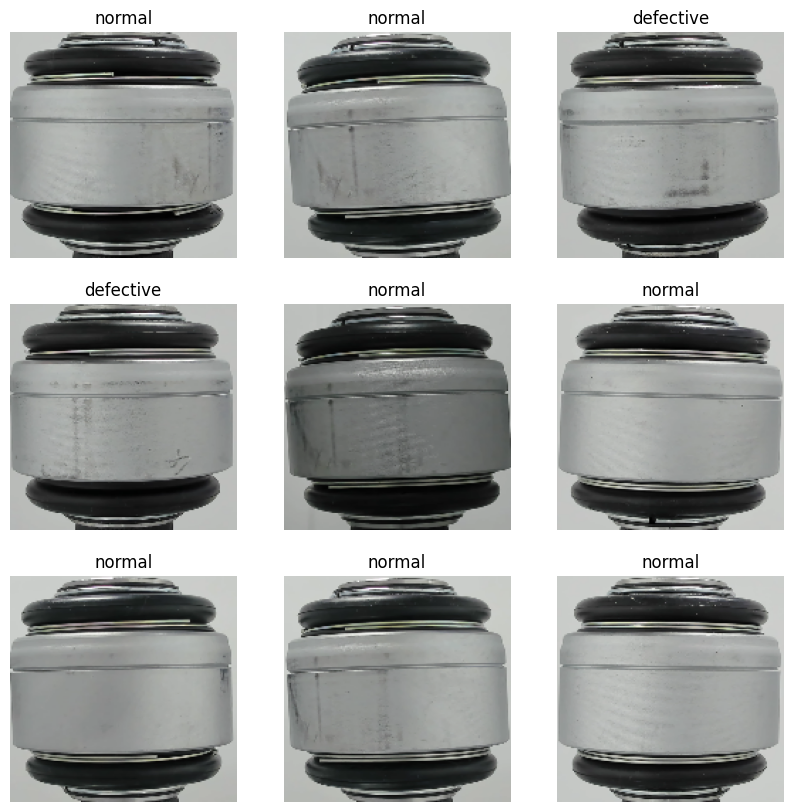

In [111]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

원본 데이터세트에는 테스트 세트가 포함되어 있지 않으므로 테스트 세트를 생성합니다. `tf.data.experimental.cardinality`를 사용하여 검증 세트에서 사용할 수 있는 데이터 배치 수를 확인한 다음 그 중 20%를 테스트 세트로 이동합니다.

In [112]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

In [113]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 5
Number of test batches: 1


### 성능을 높이도록 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O 차단 없이 디스크에서 이미지를 로드합니다. 이 방법에 대해 자세히 알아보려면 [데이터 성능](https://www.tensorflow.org/guide/data_performance) 가이드를 참조하세요.

In [114]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

### 데이터 증강 사용

큰 이미지 데이터세트가 없는 경우, 회전 및 수평 뒤집기와 같이 훈련 이미지에 무작위이지만 사실적인 변환을 적용하여 샘플 다양성을 인위적으로 도입하는 것이 좋습니다. 이것은 모델을 훈련 데이터의 다양한 측면에 노출시키고 [과대적합](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)을 줄이는 데 도움이 됩니다. 

In [115]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('vertical'),
])

참고: `model.fit`을 호출할 때 훈련 중에만 이러한 레이어가 활성화됩니다. `model.evaulate` 또는 `model.fit`의 추론 모드에서 모델을 사용하면 비활성화됩니다.

같은 이미지에 이 레이어를 반복해서 적용하고 결과를 확인해 보겠습니다.

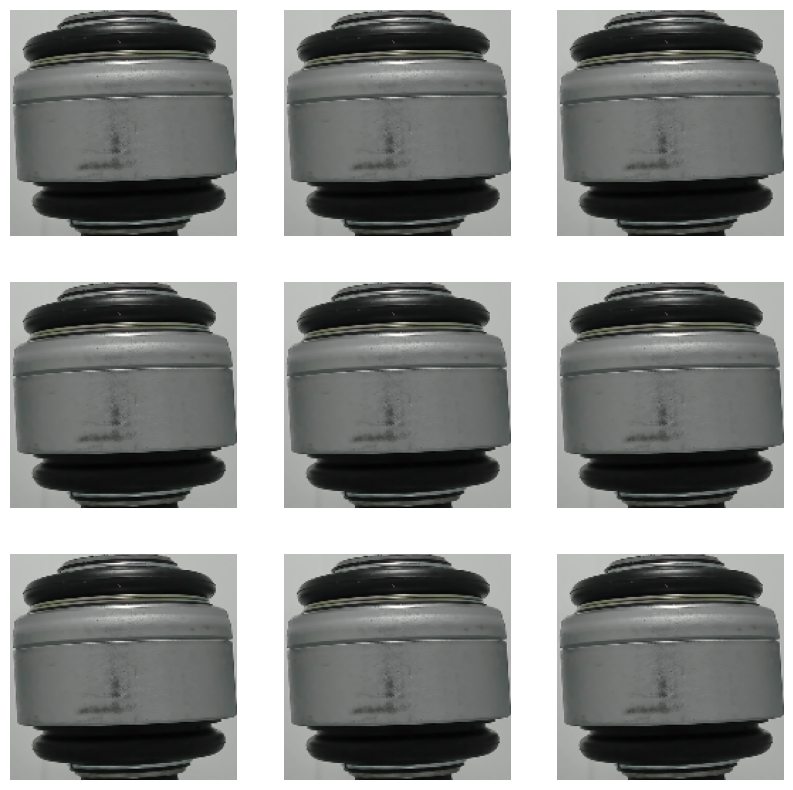

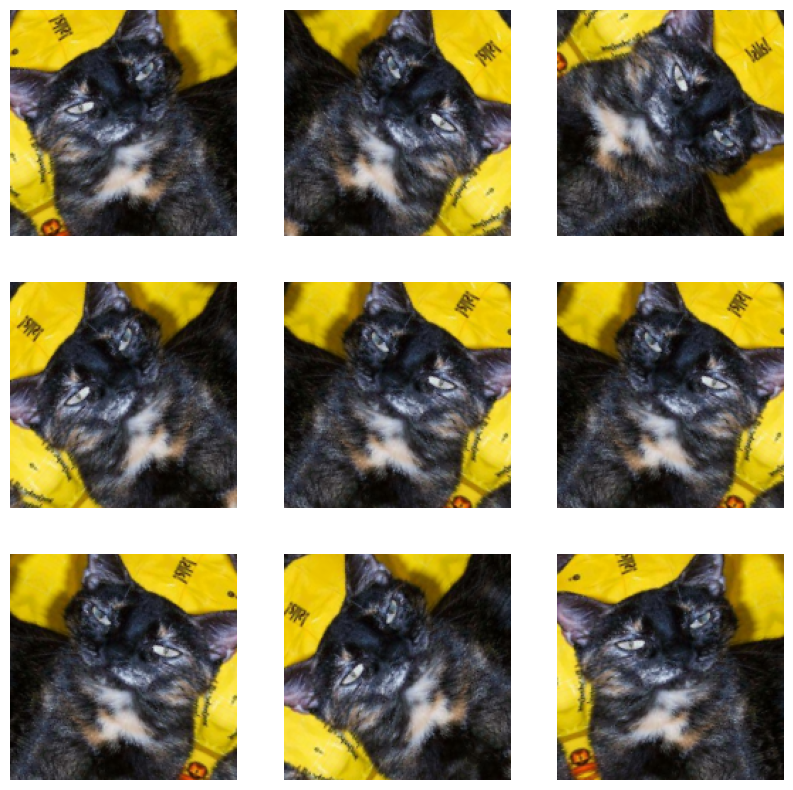

In [116]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

### 픽셀 값 재조정

잠시 후 기본 모델로 사용할 `tf.keras.applications.MobileNetV2`를 다운로드합니다. 이 모델은 `[-1, 1]`의 픽셀 값을 예상하지만 이 시점에서 이미지의 픽셀 값은 `[0, 255]`입니다. 크기를 재조정하려면 모델에 포함된 전처리 메서드를 사용하세요.

In [117]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

참고: 또는 `tf.keras.layers.Rescaling`을 사용하여 픽셀 값을 `[0, 255]`에서 `[-1, 1]`로 다시 조정할 수 있습니다.

In [118]:
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1)

## 사전 훈련된 컨볼루션 네트워크로부터 기본 모델 생성하기

In [130]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

이 특징 추출기는 각 160x160x3 이미지를 5x5x1280 개의 특징 블록으로 변환합니다. 이미지 배치 예제에서 수행하는 작업을 확인하세요:

In [131]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(16, 5, 5, 1280)


## 특징 추출

이 단계에서는 이전 단계에서 작성된 컨벌루션 베이스 모델을 동결하고 특징 추출기로 사용합니다. 또한 그 위에 분류기를 추가하고 최상위 분류기를 훈련시킵니다.

### 컨볼루션 베이스 모델 고정하기

모델을 컴파일하고 훈련하기 전에 컨볼루션 기반을 고정하는 것이 중요합니다. 동결(layer.trainable = False로 설정)은 주어진 레이어의 가중치가 훈련 중에 업데이트되는 것을 방지합니다. MobileNet V2에는 많은 레이어가 있으므로 전체 모델의 `trainable` 플래그를 False로 설정하면 레이어가 모두 동결됩니다.

In [132]:
base_model.trainable = False

### BatchNormalization 레이어에 대한 중요 참고 사항

많은 모델에는 `tf.keras.layers.BatchNormalization` 레이어가 포함되어 있습니다. 이 레이어는 특별한 경우이며 이 튜토리얼의 뒷부분에 나와 있는 것처럼 미세 조정의 맥락에서 주의를 기울여야 합니다.

`layer.trainable = False`를 설정하면 `BatchNormalization` 레이어가 추론 모드에서 실행되고 평균 및 분산 통계를 업데이트하지 않습니다.

미세 조정을 위해 BatchNormalization 레이어를 포함하는 모델을 동결 해제하면 기본 모델을 호출할 때 `training = False`를 전달하여 BatchNormalization 레이어를 추론 모드로 유지해야 합니다. 그렇지 않으면 훈련 불가능한 가중치에 적용된 업데이트로 인해 모델이 학습한 내용이 파괴됩니다.

### 분류 층을 맨 위에 추가하기

특성 블록에서 예측을 생성하기 위해 `tf.keras.layers.GlobalAveragePooling2D` 레이어를 사용하여 특성을 이미지당 하나의 1280-요소 벡터로 변환하여 `5x5` 공간 위치에 대한 평균을 구합니다.

In [133]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(16, 1280)


`tf.keras.layers.Dense` 레이어를 사용하여 특성을 이미지당 단일 예측으로 변환합니다. 이 예측은 `logit`또는 원시 예측 값으로 취급되므로 활성화 함수가 필요하지 않습니다. 양수는 클래스 1을 예측하고 음수는 클래스 0을 예측합니다.

In [134]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(16, 1)


[Keras Functional API](https://www.tensorflow.org/guide/keras/functional)를 사용하여 데이터 증강, 크기 조정, base_model 및 특성 추출기 레이어를 함께 연결하여 모델을 구축합니다. 앞서 언급했듯이 모델에 BatchNormalization 레이어가 포함되어 있으므로 training=False를 사용하세요.

In [135]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### 모델 컴파일

모델을 훈련시키기 전에 컴파일합니다. 두 개의 클래스가 있고 모델이 선형 출력을 제공하므로 `from_logits=True`와 함께 `tf.keras.losses.BinaryCrossentropy` 손실을 사용합니다.

In [136]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

MobileNet의 250만 매개변수는 고정되어 있지만 Dense 레이어에는 1200개의 *훈련 가능한* 매개변수가 있습니다. 이들은 두 개의 `tf.Variable` 객체, 즉 가중치와 편향으로 나뉩니다.

In [137]:
len(model.trainable_variables)

2

### 모델 훈련

In [138]:
initial_epochs = 100

loss0, accuracy0 = model.evaluate(validation_dataset)

5/5 [==============================] - 1s 6ms/step - loss: 0.7471 - accuracy: 0.4189


25/26 [===========================>..] - ETA: 0s - loss: 0.8329 - accuracy: 0.4450

26/26 [==============================] - ETA: 0s - loss: 0.8323 - accuracy: 0.4443

26/26 [==============================] - 2s 22ms/step - loss: 0.8323 - accuracy: 0.4443


In [139]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 0.75
initial accuracy: 0.42


In [140]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/100
6/6 [==============================] - 2s 20ms/step - loss: 0.7021 - accuracy: 0.5444 - val_loss: 0.7285 - val_accuracy: 0.4324
Epoch 2/100
6/6 [==============================] - 0s 19ms/step - loss: 0.6917 - accuracy: 0.5556 - val_loss: 0.7422 - val_accuracy: 0.4189
Epoch 3/100
6/6 [==============================] - 0s 20ms/step - loss: 0.7010 - accuracy: 0.5333 - val_loss: 0.7358 - val_accuracy: 0.4189
Epoch 4/100
6/6 [==============================] - 0s 24ms/step - loss: 0.6800 - accuracy: 0.5111 - val_loss: 0.7273 - val_accuracy: 0.4730
Epoch 5/100
6/6 [==============================] - 0s 22ms/step - loss: 0.6780 - accuracy: 0.5222 - val_loss: 0.7184 - val_accuracy: 0.4459
Epoch 6/100
6/6 [==============================] - 0s 20ms/step - loss: 0.6782 - accuracy: 0.5333 - val_loss: 0.7281 - val_accuracy: 0.5135
Epoch 7/100
6/6 [==============================] - 0s 20ms/step - loss: 0.6814 - accuracy: 0.6222 - val_loss: 0.7316 - val_accuracy: 0.5000
Epoch 8/100
6/6 [===

 1/63 [..............................] - ETA: 4:37 - loss: 0.8728 - accuracy: 0.4062

 2/63 [..............................] - ETA: 3s - loss: 0.8726 - accuracy: 0.3906  

 3/63 [>.............................] - ETA: 3s - loss: 0.9092 - accuracy: 0.4271

 4/63 [>.............................] - ETA: 3s - loss: 0.9373 - accuracy: 0.4297

 5/63 [=>............................] - ETA: 3s - loss: 0.9026 - accuracy: 0.4625

 6/63 [=>............................] - ETA: 3s - loss: 0.8572 - accuracy: 0.4844

 7/63 [==>...........................] - ETA: 3s - loss: 0.8760 - accuracy: 0.4777

 8/63 [==>...........................] - ETA: 3s - loss: 0.8539 - accuracy: 0.5039

 9/63 [===>..........................] - ETA: 3s - loss: 0.8596 - accuracy: 0.5000

10/63 [===>..........................] - ETA: 3s - loss: 0.8482 - accuracy: 0.5063

11/63 [====>.........................] - ETA: 3s - loss: 0.8559 - accuracy: 0.4943

12/63 [====>.........................] - ETA: 3s - loss: 0.8517 - accuracy: 0.4844

13/63 [=====>........................] - ETA: 3s - loss: 0.8597 - accuracy: 0.4880

14/63 [=====>........................] - ETA: 2s - loss: 0.8519 - accuracy: 0.4911

15/63 [======>.......................] - ETA: 2s - loss: 0.8521 - accuracy: 0.4896

16/63 [======>.......................] - ETA: 2s - loss: 0.8456 - accuracy: 0.4902

17/63 [=======>......................] - ETA: 2s - loss: 0.8392 - accuracy: 0.4926

18/63 [=======>......................] - ETA: 2s - loss: 0.8352 - accuracy: 0.4931

19/63 [========>.....................] - ETA: 2s - loss: 0.8364 - accuracy: 0.4951

20/63 [========>.....................] - ETA: 2s - loss: 0.8354 - accuracy: 0.4969

21/63 [=========>....................] - ETA: 2s - loss: 0.8332 - accuracy: 0.5015

22/63 [=========>....................] - ETA: 2s - loss: 0.8333 - accuracy: 0.5028

23/63 [=========>....................] - ETA: 2s - loss: 0.8321 - accuracy: 0.5027

24/63 [==========>...................] - ETA: 2s - loss: 0.8375 - accuracy: 0.4961

25/63 [==========>...................] - ETA: 2s - loss: 0.8331 - accuracy: 0.4963

26/63 [===========>..................] - ETA: 2s - loss: 0.8289 - accuracy: 0.4976

27/63 [===========>..................] - ETA: 2s - loss: 0.8279 - accuracy: 0.5035

28/63 [============>.................] - ETA: 2s - loss: 0.8235 - accuracy: 0.5056

29/63 [============>.................] - ETA: 2s - loss: 0.8206 - accuracy: 0.5065

30/63 [=============>................] - ETA: 1s - loss: 0.8217 - accuracy: 0.5042

31/63 [=============>................] - ETA: 1s - loss: 0.8146 - accuracy: 0.5071

32/63 [==============>...............] - ETA: 1s - loss: 0.8108 - accuracy: 0.5098

33/63 [==============>...............] - ETA: 1s - loss: 0.8067 - accuracy: 0.5142

34/63 [===============>..............] - ETA: 1s - loss: 0.8040 - accuracy: 0.5147

35/63 [===============>..............] - ETA: 1s - loss: 0.8066 - accuracy: 0.5143

36/63 [================>.............] - ETA: 1s - loss: 0.8045 - accuracy: 0.5174

37/63 [================>.............] - ETA: 1s - loss: 0.8101 - accuracy: 0.5177

38/63 [=================>............] - ETA: 1s - loss: 0.8062 - accuracy: 0.5197

39/63 [=================>............] - ETA: 1s - loss: 0.8056 - accuracy: 0.5192

40/63 [==================>...........] - ETA: 1s - loss: 0.8029 - accuracy: 0.5211

41/63 [==================>...........] - ETA: 1s - loss: 0.8012 - accuracy: 0.5236

42/63 [===================>..........] - ETA: 1s - loss: 0.7988 - accuracy: 0.5260

43/63 [===================>..........] - ETA: 1s - loss: 0.7959 - accuracy: 0.5254

44/63 [===================>..........] - ETA: 1s - loss: 0.7925 - accuracy: 0.5291

45/63 [====================>.........] - ETA: 1s - loss: 0.7892 - accuracy: 0.5319

46/63 [====================>.........] - ETA: 1s - loss: 0.7847 - accuracy: 0.5380

47/63 [=====================>........] - ETA: 0s - loss: 0.7831 - accuracy: 0.5359

48/63 [=====================>........] - ETA: 0s - loss: 0.7826 - accuracy: 0.5358

49/63 [======================>.......] - ETA: 0s - loss: 0.7779 - accuracy: 0.5395

50/63 [======================>.......] - ETA: 0s - loss: 0.7750 - accuracy: 0.5419

51/63 [=======================>......] - ETA: 0s - loss: 0.7731 - accuracy: 0.5417

52/63 [=======================>......] - ETA: 0s - loss: 0.7748 - accuracy: 0.5403

53/63 [========================>.....] - ETA: 0s - loss: 0.7751 - accuracy: 0.5389

54/63 [========================>.....] - ETA: 0s - loss: 0.7750 - accuracy: 0.5376

55/63 [=========================>....] - ETA: 0s - loss: 0.7757 - accuracy: 0.5381

56/63 [=========================>....] - ETA: 0s - loss: 0.7731 - accuracy: 0.5396

57/63 [==========================>...] - ETA: 0s - loss: 0.7728 - accuracy: 0.5417

58/63 [==========================>...] - ETA: 0s - loss: 0.7707 - accuracy: 0.5431

59/63 [===========================>..] - ETA: 0s - loss: 0.7675 - accuracy: 0.5434

60/63 [===========================>..] - ETA: 0s - loss: 0.7685 - accuracy: 0.5443

61/63 [============================>.] - ETA: 0s - loss: 0.7659 - accuracy: 0.5466

62/63 [============================>.] - ETA: 0s - loss: 0.7631 - accuracy: 0.5469

63/63 [==============================] - ETA: 0s - loss: 0.7613 - accuracy: 0.5480

63/63 [==============================] - 9s 69ms/step - loss: 0.7613 - accuracy: 0.5480 - val_loss: 0.5641 - val_accuracy: 0.6869


Epoch 2/10


 1/63 [..............................] - ETA: 5s - loss: 0.6502 - accuracy: 0.6875

 2/63 [..............................] - ETA: 3s - loss: 0.6372 - accuracy: 0.6562

 3/63 [>.............................] - ETA: 3s - loss: 0.6207 - accuracy: 0.6667

 4/63 [>.............................] - ETA: 3s - loss: 0.6401 - accuracy: 0.6250

 5/63 [=>............................] - ETA: 3s - loss: 0.6477 - accuracy: 0.6187

 6/63 [=>............................] - ETA: 3s - loss: 0.6534 - accuracy: 0.6146

 7/63 [==>...........................] - ETA: 3s - loss: 0.6887 - accuracy: 0.5938

 8/63 [==>...........................] - ETA: 3s - loss: 0.6892 - accuracy: 0.5898

 9/63 [===>..........................] - ETA: 3s - loss: 0.6642 - accuracy: 0.5972

10/63 [===>..........................] - ETA: 3s - loss: 0.6523 - accuracy: 0.6125

11/63 [====>.........................] - ETA: 3s - loss: 0.6516 - accuracy: 0.6136

12/63 [====>.........................] - ETA: 2s - loss: 0.6486 - accuracy: 0.6120

13/63 [=====>........................] - ETA: 2s - loss: 0.6566 - accuracy: 0.6178

14/63 [=====>........................] - ETA: 2s - loss: 0.6541 - accuracy: 0.6250

15/63 [======>.......................] - ETA: 2s - loss: 0.6442 - accuracy: 0.6271

16/63 [======>.......................] - ETA: 2s - loss: 0.6453 - accuracy: 0.6270

17/63 [=======>......................] - ETA: 2s - loss: 0.6367 - accuracy: 0.6342

18/63 [=======>......................] - ETA: 2s - loss: 0.6363 - accuracy: 0.6354

19/63 [========>.....................] - ETA: 2s - loss: 0.6394 - accuracy: 0.6365

20/63 [========>.....................] - ETA: 2s - loss: 0.6295 - accuracy: 0.6438

21/63 [=========>....................] - ETA: 2s - loss: 0.6282 - accuracy: 0.6458

22/63 [=========>....................] - ETA: 2s - loss: 0.6259 - accuracy: 0.6506

23/63 [=========>....................] - ETA: 2s - loss: 0.6277 - accuracy: 0.6495

24/63 [==========>...................] - ETA: 2s - loss: 0.6286 - accuracy: 0.6471

25/63 [==========>...................] - ETA: 2s - loss: 0.6269 - accuracy: 0.6475

26/63 [===========>..................] - ETA: 2s - loss: 0.6248 - accuracy: 0.6538

27/63 [===========>..................] - ETA: 2s - loss: 0.6229 - accuracy: 0.6493

28/63 [============>.................] - ETA: 2s - loss: 0.6191 - accuracy: 0.6529

29/63 [============>.................] - ETA: 2s - loss: 0.6201 - accuracy: 0.6552

30/63 [=============>................] - ETA: 1s - loss: 0.6154 - accuracy: 0.6594

31/63 [=============>................] - ETA: 1s - loss: 0.6135 - accuracy: 0.6593

32/63 [==============>...............] - ETA: 1s - loss: 0.6123 - accuracy: 0.6611

33/63 [==============>...............] - ETA: 1s - loss: 0.6128 - accuracy: 0.6600

34/63 [===============>..............] - ETA: 1s - loss: 0.6154 - accuracy: 0.6572

35/63 [===============>..............] - ETA: 1s - loss: 0.6106 - accuracy: 0.6598

36/63 [================>.............] - ETA: 1s - loss: 0.6095 - accuracy: 0.6597

37/63 [================>.............] - ETA: 1s - loss: 0.6104 - accuracy: 0.6562

38/63 [=================>............] - ETA: 1s - loss: 0.6054 - accuracy: 0.6604

39/63 [=================>............] - ETA: 1s - loss: 0.6013 - accuracy: 0.6635

40/63 [==================>...........] - ETA: 1s - loss: 0.5992 - accuracy: 0.6664

41/63 [==================>...........] - ETA: 1s - loss: 0.5987 - accuracy: 0.6646

42/63 [===================>..........] - ETA: 1s - loss: 0.5946 - accuracy: 0.6652

43/63 [===================>..........] - ETA: 1s - loss: 0.5937 - accuracy: 0.6657

44/63 [===================>..........] - ETA: 1s - loss: 0.5921 - accuracy: 0.6655

45/63 [====================>.........] - ETA: 1s - loss: 0.5866 - accuracy: 0.6681

46/63 [====================>.........] - ETA: 1s - loss: 0.5825 - accuracy: 0.6726

47/63 [=====================>........] - ETA: 0s - loss: 0.5786 - accuracy: 0.6735

48/63 [=====================>........] - ETA: 0s - loss: 0.5773 - accuracy: 0.6764

49/63 [======================>.......] - ETA: 0s - loss: 0.5738 - accuracy: 0.6792

50/63 [======================>.......] - ETA: 0s - loss: 0.5745 - accuracy: 0.6781

51/63 [=======================>......] - ETA: 0s - loss: 0.5739 - accuracy: 0.6783

52/63 [=======================>......] - ETA: 0s - loss: 0.5734 - accuracy: 0.6785

53/63 [========================>.....] - ETA: 0s - loss: 0.5705 - accuracy: 0.6804

54/63 [========================>.....] - ETA: 0s - loss: 0.5687 - accuracy: 0.6811

55/63 [=========================>....] - ETA: 0s - loss: 0.5691 - accuracy: 0.6807

56/63 [=========================>....] - ETA: 0s - loss: 0.5670 - accuracy: 0.6830

57/63 [==========================>...] - ETA: 0s - loss: 0.5659 - accuracy: 0.6837

58/63 [==========================>...] - ETA: 0s - loss: 0.5669 - accuracy: 0.6827

59/63 [===========================>..] - ETA: 0s - loss: 0.5658 - accuracy: 0.6843

60/63 [===========================>..] - ETA: 0s - loss: 0.5657 - accuracy: 0.6828

61/63 [============================>.] - ETA: 0s - loss: 0.5662 - accuracy: 0.6824

62/63 [============================>.] - ETA: 0s - loss: 0.5663 - accuracy: 0.6835

63/63 [==============================] - 4s 67ms/step - loss: 0.5661 - accuracy: 0.6830 - val_loss: 0.4129 - val_accuracy: 0.7809


Epoch 3/10


 1/63 [..............................] - ETA: 5s - loss: 0.4697 - accuracy: 0.7812

 2/63 [..............................] - ETA: 3s - loss: 0.4721 - accuracy: 0.7188

 3/63 [>.............................] - ETA: 3s - loss: 0.4659 - accuracy: 0.7396

 4/63 [>.............................] - ETA: 3s - loss: 0.4690 - accuracy: 0.7500

 5/63 [=>............................] - ETA: 3s - loss: 0.4737 - accuracy: 0.7312

 6/63 [=>............................] - ETA: 3s - loss: 0.4841 - accuracy: 0.7292

 7/63 [==>...........................] - ETA: 3s - loss: 0.4908 - accuracy: 0.7232

 8/63 [==>...........................] - ETA: 3s - loss: 0.5214 - accuracy: 0.7148

 9/63 [===>..........................] - ETA: 3s - loss: 0.5134 - accuracy: 0.7188

10/63 [===>..........................] - ETA: 3s - loss: 0.5136 - accuracy: 0.7094

11/63 [====>.........................] - ETA: 3s - loss: 0.5039 - accuracy: 0.7216

12/63 [====>.........................] - ETA: 3s - loss: 0.5033 - accuracy: 0.7240

13/63 [=====>........................] - ETA: 3s - loss: 0.4976 - accuracy: 0.7308

14/63 [=====>........................] - ETA: 2s - loss: 0.4938 - accuracy: 0.7299

15/63 [======>.......................] - ETA: 2s - loss: 0.4857 - accuracy: 0.7375

16/63 [======>.......................] - ETA: 2s - loss: 0.4848 - accuracy: 0.7383

17/63 [=======>......................] - ETA: 2s - loss: 0.4842 - accuracy: 0.7408

18/63 [=======>......................] - ETA: 2s - loss: 0.4804 - accuracy: 0.7483

19/63 [========>.....................] - ETA: 2s - loss: 0.4879 - accuracy: 0.7418

20/63 [========>.....................] - ETA: 2s - loss: 0.4786 - accuracy: 0.7469

21/63 [=========>....................] - ETA: 2s - loss: 0.4744 - accuracy: 0.7515

22/63 [=========>....................] - ETA: 2s - loss: 0.4766 - accuracy: 0.7486

23/63 [=========>....................] - ETA: 2s - loss: 0.4778 - accuracy: 0.7514

24/63 [==========>...................] - ETA: 2s - loss: 0.4747 - accuracy: 0.7539

25/63 [==========>...................] - ETA: 2s - loss: 0.4806 - accuracy: 0.7500

26/63 [===========>..................] - ETA: 2s - loss: 0.4806 - accuracy: 0.7500

27/63 [===========>..................] - ETA: 2s - loss: 0.4781 - accuracy: 0.7535

28/63 [============>.................] - ETA: 2s - loss: 0.4732 - accuracy: 0.7556

29/63 [============>.................] - ETA: 2s - loss: 0.4736 - accuracy: 0.7554

30/63 [=============>................] - ETA: 1s - loss: 0.4710 - accuracy: 0.7594

31/63 [=============>................] - ETA: 1s - loss: 0.4693 - accuracy: 0.7581

32/63 [==============>...............] - ETA: 1s - loss: 0.4677 - accuracy: 0.7578

33/63 [==============>...............] - ETA: 1s - loss: 0.4667 - accuracy: 0.7585

34/63 [===============>..............] - ETA: 1s - loss: 0.4669 - accuracy: 0.7564

35/63 [===============>..............] - ETA: 1s - loss: 0.4686 - accuracy: 0.7536

36/63 [================>.............] - ETA: 1s - loss: 0.4651 - accuracy: 0.7535

37/63 [================>.............] - ETA: 1s - loss: 0.4625 - accuracy: 0.7551

38/63 [=================>............] - ETA: 1s - loss: 0.4638 - accuracy: 0.7541

39/63 [=================>............] - ETA: 1s - loss: 0.4608 - accuracy: 0.7556

40/63 [==================>...........] - ETA: 1s - loss: 0.4617 - accuracy: 0.7523

41/63 [==================>...........] - ETA: 1s - loss: 0.4624 - accuracy: 0.7523

42/63 [===================>..........] - ETA: 1s - loss: 0.4588 - accuracy: 0.7552

43/63 [===================>..........] - ETA: 1s - loss: 0.4577 - accuracy: 0.7544

44/63 [===================>..........] - ETA: 1s - loss: 0.4558 - accuracy: 0.7543

45/63 [====================>.........] - ETA: 1s - loss: 0.4550 - accuracy: 0.7563

46/63 [====================>.........] - ETA: 1s - loss: 0.4560 - accuracy: 0.7548

47/63 [=====================>........] - ETA: 0s - loss: 0.4563 - accuracy: 0.7540

48/63 [=====================>........] - ETA: 0s - loss: 0.4552 - accuracy: 0.7526

49/63 [======================>.......] - ETA: 0s - loss: 0.4544 - accuracy: 0.7526

50/63 [======================>.......] - ETA: 0s - loss: 0.4547 - accuracy: 0.7538

51/63 [=======================>......] - ETA: 0s - loss: 0.4537 - accuracy: 0.7549

52/63 [=======================>......] - ETA: 0s - loss: 0.4544 - accuracy: 0.7536

53/63 [========================>.....] - ETA: 0s - loss: 0.4523 - accuracy: 0.7547

54/63 [========================>.....] - ETA: 0s - loss: 0.4531 - accuracy: 0.7546

55/63 [=========================>....] - ETA: 0s - loss: 0.4535 - accuracy: 0.7545

56/63 [=========================>....] - ETA: 0s - loss: 0.4532 - accuracy: 0.7550

57/63 [==========================>...] - ETA: 0s - loss: 0.4537 - accuracy: 0.7560

58/63 [==========================>...] - ETA: 0s - loss: 0.4540 - accuracy: 0.7570

59/63 [===========================>..] - ETA: 0s - loss: 0.4513 - accuracy: 0.7590

60/63 [===========================>..] - ETA: 0s - loss: 0.4511 - accuracy: 0.7589

61/63 [============================>.] - ETA: 0s - loss: 0.4499 - accuracy: 0.7597

62/63 [============================>.] - ETA: 0s - loss: 0.4488 - accuracy: 0.7596

63/63 [==============================] - 4s 68ms/step - loss: 0.4479 - accuracy: 0.7605 - val_loss: 0.3166 - val_accuracy: 0.8601


Epoch 4/10


 1/63 [..............................] - ETA: 5s - loss: 0.4723 - accuracy: 0.7812

 2/63 [..............................] - ETA: 3s - loss: 0.4143 - accuracy: 0.8281

 3/63 [>.............................] - ETA: 3s - loss: 0.3792 - accuracy: 0.8542

 4/63 [>.............................] - ETA: 3s - loss: 0.3588 - accuracy: 0.8672

 5/63 [=>............................] - ETA: 3s - loss: 0.3576 - accuracy: 0.8625

 6/63 [=>............................] - ETA: 3s - loss: 0.3697 - accuracy: 0.8490

 7/63 [==>...........................] - ETA: 3s - loss: 0.3872 - accuracy: 0.8259

 8/63 [==>...........................] - ETA: 3s - loss: 0.3835 - accuracy: 0.8359

 9/63 [===>..........................] - ETA: 3s - loss: 0.3842 - accuracy: 0.8333

10/63 [===>..........................] - ETA: 3s - loss: 0.3865 - accuracy: 0.8313

11/63 [====>.........................] - ETA: 3s - loss: 0.4017 - accuracy: 0.8068

12/63 [====>.........................] - ETA: 3s - loss: 0.3883 - accuracy: 0.8177

13/63 [=====>........................] - ETA: 2s - loss: 0.3807 - accuracy: 0.8245

14/63 [=====>........................] - ETA: 2s - loss: 0.3861 - accuracy: 0.8192

15/63 [======>.......................] - ETA: 2s - loss: 0.3852 - accuracy: 0.8188

16/63 [======>.......................] - ETA: 2s - loss: 0.3899 - accuracy: 0.8164

17/63 [=======>......................] - ETA: 2s - loss: 0.3852 - accuracy: 0.8180

18/63 [=======>......................] - ETA: 2s - loss: 0.3917 - accuracy: 0.8160

19/63 [========>.....................] - ETA: 2s - loss: 0.3873 - accuracy: 0.8141

20/63 [========>.....................] - ETA: 2s - loss: 0.3834 - accuracy: 0.8203

21/63 [=========>....................] - ETA: 2s - loss: 0.3829 - accuracy: 0.8185

22/63 [=========>....................] - ETA: 2s - loss: 0.3853 - accuracy: 0.8153

23/63 [=========>....................] - ETA: 2s - loss: 0.3842 - accuracy: 0.8166

24/63 [==========>...................] - ETA: 2s - loss: 0.3865 - accuracy: 0.8138

25/63 [==========>...................] - ETA: 2s - loss: 0.3842 - accuracy: 0.8163

26/63 [===========>..................] - ETA: 2s - loss: 0.3844 - accuracy: 0.8125

27/63 [===========>..................] - ETA: 2s - loss: 0.3864 - accuracy: 0.8090

28/63 [============>.................] - ETA: 2s - loss: 0.3876 - accuracy: 0.8080

29/63 [============>.................] - ETA: 2s - loss: 0.3861 - accuracy: 0.8082

30/63 [=============>................] - ETA: 1s - loss: 0.3856 - accuracy: 0.8073

31/63 [=============>................] - ETA: 1s - loss: 0.3857 - accuracy: 0.8044

32/63 [==============>...............] - ETA: 1s - loss: 0.3845 - accuracy: 0.8047

33/63 [==============>...............] - ETA: 1s - loss: 0.3851 - accuracy: 0.8030

34/63 [===============>..............] - ETA: 1s - loss: 0.3824 - accuracy: 0.8051

35/63 [===============>..............] - ETA: 1s - loss: 0.3841 - accuracy: 0.8045

36/63 [================>.............] - ETA: 1s - loss: 0.3800 - accuracy: 0.8073

37/63 [================>.............] - ETA: 1s - loss: 0.3801 - accuracy: 0.8049

38/63 [=================>............] - ETA: 1s - loss: 0.3788 - accuracy: 0.8084

39/63 [=================>............] - ETA: 1s - loss: 0.3788 - accuracy: 0.8077

40/63 [==================>...........] - ETA: 1s - loss: 0.3778 - accuracy: 0.8086

41/63 [==================>...........] - ETA: 1s - loss: 0.3758 - accuracy: 0.8095

42/63 [===================>..........] - ETA: 1s - loss: 0.3764 - accuracy: 0.8103

43/63 [===================>..........] - ETA: 1s - loss: 0.3754 - accuracy: 0.8118

44/63 [===================>..........] - ETA: 1s - loss: 0.3745 - accuracy: 0.8132

45/63 [====================>.........] - ETA: 1s - loss: 0.3755 - accuracy: 0.8118

46/63 [====================>.........] - ETA: 1s - loss: 0.3730 - accuracy: 0.8139

47/63 [=====================>........] - ETA: 0s - loss: 0.3728 - accuracy: 0.8145

48/63 [=====================>........] - ETA: 0s - loss: 0.3736 - accuracy: 0.8145

49/63 [======================>.......] - ETA: 0s - loss: 0.3710 - accuracy: 0.8163

50/63 [======================>.......] - ETA: 0s - loss: 0.3700 - accuracy: 0.8175

51/63 [=======================>......] - ETA: 0s - loss: 0.3700 - accuracy: 0.8174

52/63 [=======================>......] - ETA: 0s - loss: 0.3696 - accuracy: 0.8173

53/63 [========================>.....] - ETA: 0s - loss: 0.3718 - accuracy: 0.8160

54/63 [========================>.....] - ETA: 0s - loss: 0.3712 - accuracy: 0.8154

55/63 [=========================>....] - ETA: 0s - loss: 0.3698 - accuracy: 0.8159

56/63 [=========================>....] - ETA: 0s - loss: 0.3695 - accuracy: 0.8153

57/63 [==========================>...] - ETA: 0s - loss: 0.3690 - accuracy: 0.8152

58/63 [==========================>...] - ETA: 0s - loss: 0.3687 - accuracy: 0.8157

59/63 [===========================>..] - ETA: 0s - loss: 0.3683 - accuracy: 0.8157

60/63 [===========================>..] - ETA: 0s - loss: 0.3703 - accuracy: 0.8141

61/63 [============================>.] - ETA: 0s - loss: 0.3716 - accuracy: 0.8125

62/63 [============================>.] - ETA: 0s - loss: 0.3694 - accuracy: 0.8145

63/63 [==============================] - 4s 67ms/step - loss: 0.3709 - accuracy: 0.8145 - val_loss: 0.2574 - val_accuracy: 0.8985


Epoch 5/10


 1/63 [..............................] - ETA: 5s - loss: 0.3298 - accuracy: 0.8438

 2/63 [..............................] - ETA: 3s - loss: 0.3142 - accuracy: 0.8438

 3/63 [>.............................] - ETA: 3s - loss: 0.3054 - accuracy: 0.8542

 4/63 [>.............................] - ETA: 3s - loss: 0.3310 - accuracy: 0.8359

 5/63 [=>............................] - ETA: 3s - loss: 0.3348 - accuracy: 0.8313

 6/63 [=>............................] - ETA: 3s - loss: 0.3469 - accuracy: 0.8281

 7/63 [==>...........................] - ETA: 3s - loss: 0.3416 - accuracy: 0.8393

 8/63 [==>...........................] - ETA: 3s - loss: 0.3488 - accuracy: 0.8359

 9/63 [===>..........................] - ETA: 3s - loss: 0.3400 - accuracy: 0.8368

10/63 [===>..........................] - ETA: 3s - loss: 0.3435 - accuracy: 0.8250

11/63 [====>.........................] - ETA: 3s - loss: 0.3507 - accuracy: 0.8210

12/63 [====>.........................] - ETA: 3s - loss: 0.3480 - accuracy: 0.8307

13/63 [=====>........................] - ETA: 2s - loss: 0.3396 - accuracy: 0.8389

14/63 [=====>........................] - ETA: 2s - loss: 0.3368 - accuracy: 0.8460

15/63 [======>.......................] - ETA: 2s - loss: 0.3391 - accuracy: 0.8458

16/63 [======>.......................] - ETA: 2s - loss: 0.3411 - accuracy: 0.8438

17/63 [=======>......................] - ETA: 2s - loss: 0.3398 - accuracy: 0.8438

18/63 [=======>......................] - ETA: 2s - loss: 0.3439 - accuracy: 0.8420

19/63 [========>.....................] - ETA: 2s - loss: 0.3478 - accuracy: 0.8388

20/63 [========>.....................] - ETA: 2s - loss: 0.3458 - accuracy: 0.8406

21/63 [=========>....................] - ETA: 2s - loss: 0.3461 - accuracy: 0.8408

22/63 [=========>....................] - ETA: 2s - loss: 0.3458 - accuracy: 0.8395

23/63 [=========>....................] - ETA: 2s - loss: 0.3460 - accuracy: 0.8383

24/63 [==========>...................] - ETA: 2s - loss: 0.3424 - accuracy: 0.8398

25/63 [==========>...................] - ETA: 2s - loss: 0.3389 - accuracy: 0.8425

26/63 [===========>..................] - ETA: 2s - loss: 0.3390 - accuracy: 0.8401

27/63 [===========>..................] - ETA: 2s - loss: 0.3390 - accuracy: 0.8391

28/63 [============>.................] - ETA: 2s - loss: 0.3435 - accuracy: 0.8382

29/63 [============>.................] - ETA: 1s - loss: 0.3456 - accuracy: 0.8351

30/63 [=============>................] - ETA: 1s - loss: 0.3422 - accuracy: 0.8385

31/63 [=============>................] - ETA: 1s - loss: 0.3391 - accuracy: 0.8387

32/63 [==============>...............] - ETA: 1s - loss: 0.3382 - accuracy: 0.8350

33/63 [==============>...............] - ETA: 1s - loss: 0.3354 - accuracy: 0.8362

34/63 [===============>..............] - ETA: 1s - loss: 0.3358 - accuracy: 0.8355

35/63 [===============>..............] - ETA: 1s - loss: 0.3393 - accuracy: 0.8330

36/63 [================>.............] - ETA: 1s - loss: 0.3393 - accuracy: 0.8342

37/63 [================>.............] - ETA: 1s - loss: 0.3383 - accuracy: 0.8345

38/63 [=================>............] - ETA: 1s - loss: 0.3373 - accuracy: 0.8347

39/63 [=================>............] - ETA: 1s - loss: 0.3349 - accuracy: 0.8357

40/63 [==================>...........] - ETA: 1s - loss: 0.3352 - accuracy: 0.8352

41/63 [==================>...........] - ETA: 1s - loss: 0.3332 - accuracy: 0.8369

42/63 [===================>..........] - ETA: 1s - loss: 0.3325 - accuracy: 0.8378

43/63 [===================>..........] - ETA: 1s - loss: 0.3306 - accuracy: 0.8387

44/63 [===================>..........] - ETA: 1s - loss: 0.3317 - accuracy: 0.8381

45/63 [====================>.........] - ETA: 1s - loss: 0.3298 - accuracy: 0.8382

46/63 [====================>.........] - ETA: 1s - loss: 0.3281 - accuracy: 0.8404

47/63 [=====================>........] - ETA: 0s - loss: 0.3276 - accuracy: 0.8411

48/63 [=====================>........] - ETA: 0s - loss: 0.3268 - accuracy: 0.8405

49/63 [======================>.......] - ETA: 0s - loss: 0.3270 - accuracy: 0.8399

50/63 [======================>.......] - ETA: 0s - loss: 0.3250 - accuracy: 0.8406

51/63 [=======================>......] - ETA: 0s - loss: 0.3266 - accuracy: 0.8407

52/63 [=======================>......] - ETA: 0s - loss: 0.3246 - accuracy: 0.8419

53/63 [========================>.....] - ETA: 0s - loss: 0.3237 - accuracy: 0.8438

54/63 [========================>.....] - ETA: 0s - loss: 0.3243 - accuracy: 0.8438

55/63 [=========================>....] - ETA: 0s - loss: 0.3273 - accuracy: 0.8403

56/63 [=========================>....] - ETA: 0s - loss: 0.3285 - accuracy: 0.8393

57/63 [==========================>...] - ETA: 0s - loss: 0.3277 - accuracy: 0.8399

58/63 [==========================>...] - ETA: 0s - loss: 0.3290 - accuracy: 0.8389

59/63 [===========================>..] - ETA: 0s - loss: 0.3272 - accuracy: 0.8400

60/63 [===========================>..] - ETA: 0s - loss: 0.3280 - accuracy: 0.8391

61/63 [============================>.] - ETA: 0s - loss: 0.3265 - accuracy: 0.8402

62/63 [============================>.] - ETA: 0s - loss: 0.3248 - accuracy: 0.8412

63/63 [==============================] - 4s 66ms/step - loss: 0.3243 - accuracy: 0.8420 - val_loss: 0.2161 - val_accuracy: 0.9183


Epoch 6/10


 1/63 [..............................] - ETA: 5s - loss: 0.2791 - accuracy: 0.8750

 2/63 [..............................] - ETA: 3s - loss: 0.2510 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 3s - loss: 0.2955 - accuracy: 0.8646

 4/63 [>.............................] - ETA: 3s - loss: 0.2958 - accuracy: 0.8672

 5/63 [=>............................] - ETA: 3s - loss: 0.2992 - accuracy: 0.8625

 6/63 [=>............................] - ETA: 3s - loss: 0.2996 - accuracy: 0.8646

 7/63 [==>...........................] - ETA: 3s - loss: 0.2981 - accuracy: 0.8750

 8/63 [==>...........................] - ETA: 3s - loss: 0.3112 - accuracy: 0.8750

 9/63 [===>..........................] - ETA: 3s - loss: 0.3132 - accuracy: 0.8715

10/63 [===>..........................] - ETA: 3s - loss: 0.3069 - accuracy: 0.8781

11/63 [====>.........................] - ETA: 3s - loss: 0.3039 - accuracy: 0.8778

12/63 [====>.........................] - ETA: 3s - loss: 0.3013 - accuracy: 0.8802

13/63 [=====>........................] - ETA: 2s - loss: 0.2988 - accuracy: 0.8798

14/63 [=====>........................] - ETA: 2s - loss: 0.2967 - accuracy: 0.8817

15/63 [======>.......................] - ETA: 2s - loss: 0.2998 - accuracy: 0.8813

16/63 [======>.......................] - ETA: 2s - loss: 0.2935 - accuracy: 0.8867

17/63 [=======>......................] - ETA: 2s - loss: 0.2952 - accuracy: 0.8860

18/63 [=======>......................] - ETA: 2s - loss: 0.2932 - accuracy: 0.8854

19/63 [========>.....................] - ETA: 2s - loss: 0.2901 - accuracy: 0.8832

20/63 [========>.....................] - ETA: 2s - loss: 0.2939 - accuracy: 0.8781

21/63 [=========>....................] - ETA: 2s - loss: 0.2991 - accuracy: 0.8735

22/63 [=========>....................] - ETA: 2s - loss: 0.2970 - accuracy: 0.8764

23/63 [=========>....................] - ETA: 2s - loss: 0.2986 - accuracy: 0.8750

24/63 [==========>...................] - ETA: 2s - loss: 0.2993 - accuracy: 0.8737

25/63 [==========>...................] - ETA: 2s - loss: 0.2972 - accuracy: 0.8763

26/63 [===========>..................] - ETA: 2s - loss: 0.2956 - accuracy: 0.8774

27/63 [===========>..................] - ETA: 2s - loss: 0.2951 - accuracy: 0.8773

28/63 [============>.................] - ETA: 2s - loss: 0.2927 - accuracy: 0.8795

29/63 [============>.................] - ETA: 2s - loss: 0.2883 - accuracy: 0.8815

30/63 [=============>................] - ETA: 1s - loss: 0.2902 - accuracy: 0.8802

31/63 [=============>................] - ETA: 1s - loss: 0.2879 - accuracy: 0.8821

32/63 [==============>...............] - ETA: 1s - loss: 0.2865 - accuracy: 0.8828

33/63 [==============>...............] - ETA: 1s - loss: 0.2847 - accuracy: 0.8835

34/63 [===============>..............] - ETA: 1s - loss: 0.2853 - accuracy: 0.8824

35/63 [===============>..............] - ETA: 1s - loss: 0.2855 - accuracy: 0.8813

36/63 [================>.............] - ETA: 1s - loss: 0.2879 - accuracy: 0.8785

37/63 [================>.............] - ETA: 1s - loss: 0.2874 - accuracy: 0.8792

38/63 [=================>............] - ETA: 1s - loss: 0.2907 - accuracy: 0.8734

39/63 [=================>............] - ETA: 1s - loss: 0.2895 - accuracy: 0.8742

40/63 [==================>...........] - ETA: 1s - loss: 0.2898 - accuracy: 0.8734

41/63 [==================>...........] - ETA: 1s - loss: 0.2878 - accuracy: 0.8750

42/63 [===================>..........] - ETA: 1s - loss: 0.2884 - accuracy: 0.8743

43/63 [===================>..........] - ETA: 1s - loss: 0.2878 - accuracy: 0.8750

44/63 [===================>..........] - ETA: 1s - loss: 0.2890 - accuracy: 0.8750

45/63 [====================>.........] - ETA: 1s - loss: 0.2854 - accuracy: 0.8778

46/63 [====================>.........] - ETA: 1s - loss: 0.2875 - accuracy: 0.8750

47/63 [=====================>........] - ETA: 0s - loss: 0.2866 - accuracy: 0.8763

48/63 [=====================>........] - ETA: 0s - loss: 0.2858 - accuracy: 0.8757

49/63 [======================>.......] - ETA: 0s - loss: 0.2854 - accuracy: 0.8750

50/63 [======================>.......] - ETA: 0s - loss: 0.2851 - accuracy: 0.8744

51/63 [=======================>......] - ETA: 0s - loss: 0.2848 - accuracy: 0.8750

52/63 [=======================>......] - ETA: 0s - loss: 0.2870 - accuracy: 0.8720

53/63 [========================>.....] - ETA: 0s - loss: 0.2899 - accuracy: 0.8697

54/63 [========================>.....] - ETA: 0s - loss: 0.2880 - accuracy: 0.8704

55/63 [=========================>....] - ETA: 0s - loss: 0.2879 - accuracy: 0.8710

56/63 [=========================>....] - ETA: 0s - loss: 0.2906 - accuracy: 0.8689

57/63 [==========================>...] - ETA: 0s - loss: 0.2932 - accuracy: 0.8673

58/63 [==========================>...] - ETA: 0s - loss: 0.2913 - accuracy: 0.8691

59/63 [===========================>..] - ETA: 0s - loss: 0.2913 - accuracy: 0.8697

60/63 [===========================>..] - ETA: 0s - loss: 0.2911 - accuracy: 0.8693

61/63 [============================>.] - ETA: 0s - loss: 0.2907 - accuracy: 0.8694

62/63 [============================>.] - ETA: 0s - loss: 0.2898 - accuracy: 0.8705

63/63 [==============================] - 4s 67ms/step - loss: 0.2889 - accuracy: 0.8710 - val_loss: 0.1840 - val_accuracy: 0.9431


Epoch 7/10


 1/63 [..............................] - ETA: 5s - loss: 0.2413 - accuracy: 0.8125

 2/63 [..............................] - ETA: 3s - loss: 0.2894 - accuracy: 0.7969

 3/63 [>.............................] - ETA: 3s - loss: 0.2635 - accuracy: 0.8438

 4/63 [>.............................] - ETA: 3s - loss: 0.3155 - accuracy: 0.8359

 5/63 [=>............................] - ETA: 3s - loss: 0.3112 - accuracy: 0.8500

 6/63 [=>............................] - ETA: 3s - loss: 0.2985 - accuracy: 0.8646

 7/63 [==>...........................] - ETA: 3s - loss: 0.2893 - accuracy: 0.8705

 8/63 [==>...........................] - ETA: 3s - loss: 0.2862 - accuracy: 0.8711

 9/63 [===>..........................] - ETA: 3s - loss: 0.2880 - accuracy: 0.8681

10/63 [===>..........................] - ETA: 3s - loss: 0.2931 - accuracy: 0.8562

11/63 [====>.........................] - ETA: 3s - loss: 0.2875 - accuracy: 0.8665

12/63 [====>.........................] - ETA: 3s - loss: 0.2842 - accuracy: 0.8672

13/63 [=====>........................] - ETA: 3s - loss: 0.2821 - accuracy: 0.8726

14/63 [=====>........................] - ETA: 2s - loss: 0.2806 - accuracy: 0.8750

15/63 [======>.......................] - ETA: 2s - loss: 0.2783 - accuracy: 0.8771

16/63 [======>.......................] - ETA: 2s - loss: 0.2846 - accuracy: 0.8691

17/63 [=======>......................] - ETA: 2s - loss: 0.2813 - accuracy: 0.8713

18/63 [=======>......................] - ETA: 2s - loss: 0.2849 - accuracy: 0.8646

19/63 [========>.....................] - ETA: 2s - loss: 0.2801 - accuracy: 0.8684

20/63 [========>.....................] - ETA: 2s - loss: 0.2816 - accuracy: 0.8656

21/63 [=========>....................] - ETA: 2s - loss: 0.2832 - accuracy: 0.8676

22/63 [=========>....................] - ETA: 2s - loss: 0.2793 - accuracy: 0.8707

23/63 [=========>....................] - ETA: 2s - loss: 0.2782 - accuracy: 0.8723

24/63 [==========>...................] - ETA: 2s - loss: 0.2769 - accuracy: 0.8711

25/63 [==========>...................] - ETA: 2s - loss: 0.2777 - accuracy: 0.8725

26/63 [===========>..................] - ETA: 2s - loss: 0.2783 - accuracy: 0.8726

27/63 [===========>..................] - ETA: 2s - loss: 0.2750 - accuracy: 0.8738

28/63 [============>.................] - ETA: 2s - loss: 0.2770 - accuracy: 0.8739

29/63 [============>.................] - ETA: 2s - loss: 0.2749 - accuracy: 0.8761

30/63 [=============>................] - ETA: 1s - loss: 0.2724 - accuracy: 0.8771

31/63 [=============>................] - ETA: 1s - loss: 0.2728 - accuracy: 0.8780

32/63 [==============>...............] - ETA: 1s - loss: 0.2711 - accuracy: 0.8799

33/63 [==============>...............] - ETA: 1s - loss: 0.2703 - accuracy: 0.8788

34/63 [===============>..............] - ETA: 1s - loss: 0.2681 - accuracy: 0.8787

35/63 [===============>..............] - ETA: 1s - loss: 0.2695 - accuracy: 0.8750

36/63 [================>.............] - ETA: 1s - loss: 0.2697 - accuracy: 0.8750

37/63 [================>.............] - ETA: 1s - loss: 0.2679 - accuracy: 0.8767

38/63 [=================>............] - ETA: 1s - loss: 0.2671 - accuracy: 0.8758

39/63 [=================>............] - ETA: 1s - loss: 0.2683 - accuracy: 0.8758

40/63 [==================>...........] - ETA: 1s - loss: 0.2667 - accuracy: 0.8773

41/63 [==================>...........] - ETA: 1s - loss: 0.2673 - accuracy: 0.8780

42/63 [===================>..........] - ETA: 1s - loss: 0.2668 - accuracy: 0.8780

43/63 [===================>..........] - ETA: 1s - loss: 0.2662 - accuracy: 0.8772

44/63 [===================>..........] - ETA: 1s - loss: 0.2640 - accuracy: 0.8793

45/63 [====================>.........] - ETA: 1s - loss: 0.2636 - accuracy: 0.8792

46/63 [====================>.........] - ETA: 1s - loss: 0.2638 - accuracy: 0.8804

47/63 [=====================>........] - ETA: 0s - loss: 0.2631 - accuracy: 0.8810

48/63 [=====================>........] - ETA: 0s - loss: 0.2624 - accuracy: 0.8809

49/63 [======================>.......] - ETA: 0s - loss: 0.2644 - accuracy: 0.8807

50/63 [======================>.......] - ETA: 0s - loss: 0.2629 - accuracy: 0.8806

51/63 [=======================>......] - ETA: 0s - loss: 0.2628 - accuracy: 0.8805

52/63 [=======================>......] - ETA: 0s - loss: 0.2618 - accuracy: 0.8816

53/63 [========================>.....] - ETA: 0s - loss: 0.2614 - accuracy: 0.8827

54/63 [========================>.....] - ETA: 0s - loss: 0.2595 - accuracy: 0.8825

55/63 [=========================>....] - ETA: 0s - loss: 0.2590 - accuracy: 0.8818

56/63 [=========================>....] - ETA: 0s - loss: 0.2576 - accuracy: 0.8828

57/63 [==========================>...] - ETA: 0s - loss: 0.2596 - accuracy: 0.8810

58/63 [==========================>...] - ETA: 0s - loss: 0.2596 - accuracy: 0.8804

59/63 [===========================>..] - ETA: 0s - loss: 0.2597 - accuracy: 0.8803

60/63 [===========================>..] - ETA: 0s - loss: 0.2601 - accuracy: 0.8786

61/63 [============================>.] - ETA: 0s - loss: 0.2607 - accuracy: 0.8781

62/63 [============================>.] - ETA: 0s - loss: 0.2595 - accuracy: 0.8785

63/63 [==============================] - 4s 68ms/step - loss: 0.2617 - accuracy: 0.8770 - val_loss: 0.1660 - val_accuracy: 0.9418


Epoch 8/10


 1/63 [..............................] - ETA: 5s - loss: 0.3074 - accuracy: 0.8438

 2/63 [..............................] - ETA: 3s - loss: 0.3214 - accuracy: 0.8281

 3/63 [>.............................] - ETA: 3s - loss: 0.2779 - accuracy: 0.8542

 4/63 [>.............................] - ETA: 3s - loss: 0.2742 - accuracy: 0.8594

 5/63 [=>............................] - ETA: 3s - loss: 0.2742 - accuracy: 0.8750

 6/63 [=>............................] - ETA: 3s - loss: 0.2586 - accuracy: 0.8906

 7/63 [==>...........................] - ETA: 3s - loss: 0.2659 - accuracy: 0.8884

 8/63 [==>...........................] - ETA: 3s - loss: 0.2627 - accuracy: 0.8906

 9/63 [===>..........................] - ETA: 3s - loss: 0.2586 - accuracy: 0.8924

10/63 [===>..........................] - ETA: 3s - loss: 0.2444 - accuracy: 0.8969

11/63 [====>.........................] - ETA: 3s - loss: 0.2427 - accuracy: 0.8977

12/63 [====>.........................] - ETA: 3s - loss: 0.2501 - accuracy: 0.8932

13/63 [=====>........................] - ETA: 2s - loss: 0.2481 - accuracy: 0.8966

14/63 [=====>........................] - ETA: 2s - loss: 0.2548 - accuracy: 0.8951

15/63 [======>.......................] - ETA: 2s - loss: 0.2550 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 2s - loss: 0.2503 - accuracy: 0.9043

17/63 [=======>......................] - ETA: 2s - loss: 0.2522 - accuracy: 0.9007

18/63 [=======>......................] - ETA: 2s - loss: 0.2562 - accuracy: 0.8976

19/63 [========>.....................] - ETA: 2s - loss: 0.2582 - accuracy: 0.8947

20/63 [========>.....................] - ETA: 2s - loss: 0.2603 - accuracy: 0.8953

21/63 [=========>....................] - ETA: 2s - loss: 0.2586 - accuracy: 0.8973

22/63 [=========>....................] - ETA: 2s - loss: 0.2532 - accuracy: 0.8991

23/63 [=========>....................] - ETA: 2s - loss: 0.2512 - accuracy: 0.9035

24/63 [==========>...................] - ETA: 2s - loss: 0.2516 - accuracy: 0.9049

25/63 [==========>...................] - ETA: 2s - loss: 0.2511 - accuracy: 0.9025

26/63 [===========>..................] - ETA: 2s - loss: 0.2537 - accuracy: 0.9014

27/63 [===========>..................] - ETA: 2s - loss: 0.2548 - accuracy: 0.8993

28/63 [============>.................] - ETA: 2s - loss: 0.2535 - accuracy: 0.8984

29/63 [============>.................] - ETA: 2s - loss: 0.2529 - accuracy: 0.8987

30/63 [=============>................] - ETA: 1s - loss: 0.2541 - accuracy: 0.8958

31/63 [=============>................] - ETA: 1s - loss: 0.2533 - accuracy: 0.8972

32/63 [==============>...............] - ETA: 1s - loss: 0.2524 - accuracy: 0.8965

33/63 [==============>...............] - ETA: 1s - loss: 0.2515 - accuracy: 0.8977

34/63 [===============>..............] - ETA: 1s - loss: 0.2546 - accuracy: 0.8952

35/63 [===============>..............] - ETA: 1s - loss: 0.2528 - accuracy: 0.8955

36/63 [================>.............] - ETA: 1s - loss: 0.2508 - accuracy: 0.8976

37/63 [================>.............] - ETA: 1s - loss: 0.2513 - accuracy: 0.8961

38/63 [=================>............] - ETA: 1s - loss: 0.2490 - accuracy: 0.8980

39/63 [=================>............] - ETA: 1s - loss: 0.2487 - accuracy: 0.8982

40/63 [==================>...........] - ETA: 1s - loss: 0.2514 - accuracy: 0.8969

41/63 [==================>...........] - ETA: 1s - loss: 0.2524 - accuracy: 0.8956

42/63 [===================>..........] - ETA: 1s - loss: 0.2489 - accuracy: 0.8973

43/63 [===================>..........] - ETA: 1s - loss: 0.2490 - accuracy: 0.8983

44/63 [===================>..........] - ETA: 1s - loss: 0.2487 - accuracy: 0.8977

45/63 [====================>.........] - ETA: 1s - loss: 0.2492 - accuracy: 0.8986

46/63 [====================>.........] - ETA: 1s - loss: 0.2479 - accuracy: 0.8988

47/63 [=====================>........] - ETA: 0s - loss: 0.2462 - accuracy: 0.8983

48/63 [=====================>........] - ETA: 0s - loss: 0.2442 - accuracy: 0.8997

49/63 [======================>.......] - ETA: 0s - loss: 0.2449 - accuracy: 0.8992

50/63 [======================>.......] - ETA: 0s - loss: 0.2466 - accuracy: 0.8969

51/63 [=======================>......] - ETA: 0s - loss: 0.2461 - accuracy: 0.8977

52/63 [=======================>......] - ETA: 0s - loss: 0.2463 - accuracy: 0.8966

53/63 [========================>.....] - ETA: 0s - loss: 0.2469 - accuracy: 0.8962

54/63 [========================>.....] - ETA: 0s - loss: 0.2478 - accuracy: 0.8953

55/63 [=========================>....] - ETA: 0s - loss: 0.2469 - accuracy: 0.8960

56/63 [=========================>....] - ETA: 0s - loss: 0.2473 - accuracy: 0.8956

57/63 [==========================>...] - ETA: 0s - loss: 0.2465 - accuracy: 0.8958

58/63 [==========================>...] - ETA: 0s - loss: 0.2470 - accuracy: 0.8949

59/63 [===========================>..] - ETA: 0s - loss: 0.2472 - accuracy: 0.8935

60/63 [===========================>..] - ETA: 0s - loss: 0.2491 - accuracy: 0.8932

61/63 [============================>.] - ETA: 0s - loss: 0.2508 - accuracy: 0.8914

62/63 [============================>.] - ETA: 0s - loss: 0.2501 - accuracy: 0.8916

63/63 [==============================] - 4s 68ms/step - loss: 0.2503 - accuracy: 0.8915 - val_loss: 0.1458 - val_accuracy: 0.9530


Epoch 9/10


 1/63 [..............................] - ETA: 5s - loss: 0.1809 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.2676 - accuracy: 0.8750

 3/63 [>.............................] - ETA: 3s - loss: 0.2393 - accuracy: 0.8854

 4/63 [>.............................] - ETA: 3s - loss: 0.2427 - accuracy: 0.8906

 5/63 [=>............................] - ETA: 3s - loss: 0.2379 - accuracy: 0.9000

 6/63 [=>............................] - ETA: 3s - loss: 0.2216 - accuracy: 0.9115

 7/63 [==>...........................] - ETA: 3s - loss: 0.2411 - accuracy: 0.8973

 8/63 [==>...........................] - ETA: 3s - loss: 0.2343 - accuracy: 0.9023

 9/63 [===>..........................] - ETA: 3s - loss: 0.2391 - accuracy: 0.9028

10/63 [===>..........................] - ETA: 3s - loss: 0.2367 - accuracy: 0.9062

11/63 [====>.........................] - ETA: 3s - loss: 0.2406 - accuracy: 0.9062

12/63 [====>.........................] - ETA: 3s - loss: 0.2358 - accuracy: 0.9062

13/63 [=====>........................] - ETA: 3s - loss: 0.2310 - accuracy: 0.9062

14/63 [=====>........................] - ETA: 2s - loss: 0.2282 - accuracy: 0.9107

15/63 [======>.......................] - ETA: 2s - loss: 0.2391 - accuracy: 0.9000

16/63 [======>.......................] - ETA: 2s - loss: 0.2448 - accuracy: 0.9004

17/63 [=======>......................] - ETA: 2s - loss: 0.2455 - accuracy: 0.9007

18/63 [=======>......................] - ETA: 2s - loss: 0.2412 - accuracy: 0.9062

19/63 [========>.....................] - ETA: 2s - loss: 0.2404 - accuracy: 0.9046

20/63 [========>.....................] - ETA: 2s - loss: 0.2388 - accuracy: 0.9062

21/63 [=========>....................] - ETA: 2s - loss: 0.2381 - accuracy: 0.9077

22/63 [=========>....................] - ETA: 2s - loss: 0.2348 - accuracy: 0.9091

23/63 [=========>....................] - ETA: 2s - loss: 0.2300 - accuracy: 0.9103

24/63 [==========>...................] - ETA: 2s - loss: 0.2277 - accuracy: 0.9115

25/63 [==========>...................] - ETA: 2s - loss: 0.2287 - accuracy: 0.9112

26/63 [===========>..................] - ETA: 2s - loss: 0.2283 - accuracy: 0.9111

27/63 [===========>..................] - ETA: 2s - loss: 0.2276 - accuracy: 0.9109

28/63 [============>.................] - ETA: 2s - loss: 0.2281 - accuracy: 0.9107

29/63 [============>.................] - ETA: 2s - loss: 0.2277 - accuracy: 0.9106

30/63 [=============>................] - ETA: 1s - loss: 0.2285 - accuracy: 0.9094

31/63 [=============>................] - ETA: 1s - loss: 0.2290 - accuracy: 0.9083

32/63 [==============>...............] - ETA: 1s - loss: 0.2276 - accuracy: 0.9111

33/63 [==============>...............] - ETA: 1s - loss: 0.2257 - accuracy: 0.9129

34/63 [===============>..............] - ETA: 1s - loss: 0.2252 - accuracy: 0.9127

35/63 [===============>..............] - ETA: 1s - loss: 0.2247 - accuracy: 0.9107

36/63 [================>.............] - ETA: 1s - loss: 0.2292 - accuracy: 0.9071

37/63 [================>.............] - ETA: 1s - loss: 0.2282 - accuracy: 0.9079

38/63 [=================>............] - ETA: 1s - loss: 0.2282 - accuracy: 0.9087

39/63 [=================>............] - ETA: 1s - loss: 0.2277 - accuracy: 0.9079

40/63 [==================>...........] - ETA: 1s - loss: 0.2282 - accuracy: 0.9086

41/63 [==================>...........] - ETA: 1s - loss: 0.2309 - accuracy: 0.9062

42/63 [===================>..........] - ETA: 1s - loss: 0.2313 - accuracy: 0.9062

43/63 [===================>..........] - ETA: 1s - loss: 0.2319 - accuracy: 0.9048

44/63 [===================>..........] - ETA: 1s - loss: 0.2304 - accuracy: 0.9062

45/63 [====================>.........] - ETA: 1s - loss: 0.2306 - accuracy: 0.9049

46/63 [====================>.........] - ETA: 1s - loss: 0.2305 - accuracy: 0.9049

47/63 [=====================>........] - ETA: 0s - loss: 0.2314 - accuracy: 0.9036

48/63 [=====================>........] - ETA: 0s - loss: 0.2322 - accuracy: 0.9043

49/63 [======================>.......] - ETA: 0s - loss: 0.2322 - accuracy: 0.9037

50/63 [======================>.......] - ETA: 0s - loss: 0.2311 - accuracy: 0.9050

51/63 [=======================>......] - ETA: 0s - loss: 0.2292 - accuracy: 0.9056

52/63 [=======================>......] - ETA: 0s - loss: 0.2292 - accuracy: 0.9044

53/63 [========================>.....] - ETA: 0s - loss: 0.2285 - accuracy: 0.9057

54/63 [========================>.....] - ETA: 0s - loss: 0.2306 - accuracy: 0.9039

55/63 [=========================>....] - ETA: 0s - loss: 0.2302 - accuracy: 0.9045

56/63 [=========================>....] - ETA: 0s - loss: 0.2300 - accuracy: 0.9046

57/63 [==========================>...] - ETA: 0s - loss: 0.2301 - accuracy: 0.9046

58/63 [==========================>...] - ETA: 0s - loss: 0.2293 - accuracy: 0.9046

59/63 [===========================>..] - ETA: 0s - loss: 0.2310 - accuracy: 0.9036

60/63 [===========================>..] - ETA: 0s - loss: 0.2297 - accuracy: 0.9042

61/63 [============================>.] - ETA: 0s - loss: 0.2278 - accuracy: 0.9057

62/63 [============================>.] - ETA: 0s - loss: 0.2284 - accuracy: 0.9042

63/63 [==============================] - 4s 67ms/step - loss: 0.2286 - accuracy: 0.9040 - val_loss: 0.1368 - val_accuracy: 0.9592


Epoch 10/10


 1/63 [..............................] - ETA: 5s - loss: 0.2940 - accuracy: 0.8750

 2/63 [..............................] - ETA: 3s - loss: 0.3474 - accuracy: 0.8125

 3/63 [>.............................] - ETA: 3s - loss: 0.3434 - accuracy: 0.8333

 4/63 [>.............................] - ETA: 3s - loss: 0.3081 - accuracy: 0.8594

 5/63 [=>............................] - ETA: 3s - loss: 0.2953 - accuracy: 0.8562

 6/63 [=>............................] - ETA: 3s - loss: 0.2740 - accuracy: 0.8646

 7/63 [==>...........................] - ETA: 3s - loss: 0.2539 - accuracy: 0.8795

 8/63 [==>...........................] - ETA: 3s - loss: 0.2628 - accuracy: 0.8789

 9/63 [===>..........................] - ETA: 3s - loss: 0.2620 - accuracy: 0.8819

10/63 [===>..........................] - ETA: 3s - loss: 0.2617 - accuracy: 0.8781

11/63 [====>.........................] - ETA: 3s - loss: 0.2589 - accuracy: 0.8807

12/63 [====>.........................] - ETA: 2s - loss: 0.2509 - accuracy: 0.8854

13/63 [=====>........................] - ETA: 2s - loss: 0.2436 - accuracy: 0.8918

14/63 [=====>........................] - ETA: 2s - loss: 0.2435 - accuracy: 0.8973

15/63 [======>.......................] - ETA: 2s - loss: 0.2442 - accuracy: 0.8979

16/63 [======>.......................] - ETA: 2s - loss: 0.2435 - accuracy: 0.8984

17/63 [=======>......................] - ETA: 2s - loss: 0.2479 - accuracy: 0.8952

18/63 [=======>......................] - ETA: 2s - loss: 0.2498 - accuracy: 0.8924

19/63 [========>.....................] - ETA: 2s - loss: 0.2500 - accuracy: 0.8914

20/63 [========>.....................] - ETA: 2s - loss: 0.2488 - accuracy: 0.8922

21/63 [=========>....................] - ETA: 2s - loss: 0.2524 - accuracy: 0.8899

22/63 [=========>....................] - ETA: 2s - loss: 0.2489 - accuracy: 0.8906

23/63 [=========>....................] - ETA: 2s - loss: 0.2471 - accuracy: 0.8940

24/63 [==========>...................] - ETA: 2s - loss: 0.2435 - accuracy: 0.8958

25/63 [==========>...................] - ETA: 2s - loss: 0.2398 - accuracy: 0.9000

26/63 [===========>..................] - ETA: 2s - loss: 0.2424 - accuracy: 0.8978

27/63 [===========>..................] - ETA: 2s - loss: 0.2398 - accuracy: 0.9005

28/63 [============>.................] - ETA: 2s - loss: 0.2393 - accuracy: 0.8996

29/63 [============>.................] - ETA: 2s - loss: 0.2383 - accuracy: 0.9009

30/63 [=============>................] - ETA: 1s - loss: 0.2370 - accuracy: 0.9010

31/63 [=============>................] - ETA: 1s - loss: 0.2377 - accuracy: 0.9012

32/63 [==============>...............] - ETA: 1s - loss: 0.2367 - accuracy: 0.9023

33/63 [==============>...............] - ETA: 1s - loss: 0.2387 - accuracy: 0.9015

34/63 [===============>..............] - ETA: 1s - loss: 0.2354 - accuracy: 0.9035

35/63 [===============>..............] - ETA: 1s - loss: 0.2323 - accuracy: 0.9054

36/63 [================>.............] - ETA: 1s - loss: 0.2310 - accuracy: 0.9062

37/63 [================>.............] - ETA: 1s - loss: 0.2299 - accuracy: 0.9071

38/63 [=================>............] - ETA: 1s - loss: 0.2296 - accuracy: 0.9071

39/63 [=================>............] - ETA: 1s - loss: 0.2302 - accuracy: 0.9087

40/63 [==================>...........] - ETA: 1s - loss: 0.2295 - accuracy: 0.9102

41/63 [==================>...........] - ETA: 1s - loss: 0.2292 - accuracy: 0.9101

42/63 [===================>..........] - ETA: 1s - loss: 0.2269 - accuracy: 0.9115

43/63 [===================>..........] - ETA: 1s - loss: 0.2273 - accuracy: 0.9106

44/63 [===================>..........] - ETA: 1s - loss: 0.2262 - accuracy: 0.9105

45/63 [====================>.........] - ETA: 1s - loss: 0.2288 - accuracy: 0.9090

46/63 [====================>.........] - ETA: 1s - loss: 0.2277 - accuracy: 0.9096

47/63 [=====================>........] - ETA: 0s - loss: 0.2259 - accuracy: 0.9109

48/63 [=====================>........] - ETA: 0s - loss: 0.2263 - accuracy: 0.9095

49/63 [======================>.......] - ETA: 0s - loss: 0.2262 - accuracy: 0.9088

50/63 [======================>.......] - ETA: 0s - loss: 0.2263 - accuracy: 0.9081

51/63 [=======================>......] - ETA: 0s - loss: 0.2260 - accuracy: 0.9081

52/63 [=======================>......] - ETA: 0s - loss: 0.2257 - accuracy: 0.9087

53/63 [========================>.....] - ETA: 0s - loss: 0.2267 - accuracy: 0.9086

54/63 [========================>.....] - ETA: 0s - loss: 0.2287 - accuracy: 0.9074

55/63 [=========================>....] - ETA: 0s - loss: 0.2268 - accuracy: 0.9085

56/63 [=========================>....] - ETA: 0s - loss: 0.2281 - accuracy: 0.9074

57/63 [==========================>...] - ETA: 0s - loss: 0.2264 - accuracy: 0.9084

58/63 [==========================>...] - ETA: 0s - loss: 0.2260 - accuracy: 0.9089

59/63 [===========================>..] - ETA: 0s - loss: 0.2256 - accuracy: 0.9084

60/63 [===========================>..] - ETA: 0s - loss: 0.2255 - accuracy: 0.9094

61/63 [============================>.] - ETA: 0s - loss: 0.2245 - accuracy: 0.9103

62/63 [============================>.] - ETA: 0s - loss: 0.2252 - accuracy: 0.9093

63/63 [==============================] - 4s 66ms/step - loss: 0.2270 - accuracy: 0.9080 - val_loss: 0.1258 - val_accuracy: 0.9629


### 학습 곡선

MobileNet V2 기본 모델을 고정된 특징 추출기로 사용했을 때의 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다.

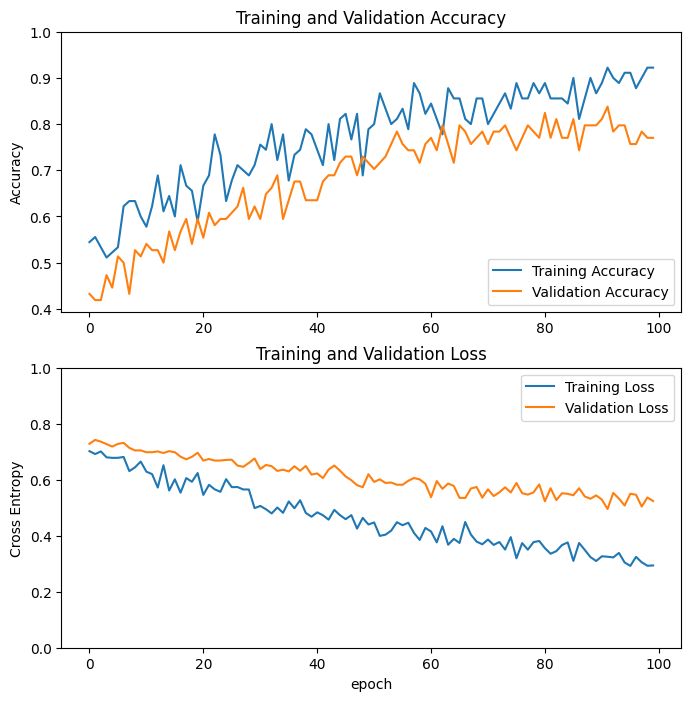

In [141]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

Note: 유효성 검사 지표가 훈련 지표보다 명확하게 더 나은 이유는 `tf.keras.layers.BatchNormalization` 및 `tf.keras.layers.Dropout`과 같은 층이 훈련 중 정확도에 영향을 주기 때문입니다. 이것들은 유효성 검사 손실을 계산할 때 해제됩니다.

이보다는 적은 이유이겠지만, 훈련 메트릭이 한 epoch 동안의 평균을 평가하는 반면, 검증 메트릭은 epoch 이후에 평가되므로 검증 메트릭이 약간 더 오래 훈련된 모델을 볼 수 있기 때문입니다.

## 미세 조정

기능 추출 실험에서는 MobileNet V2 기본 모델을 기반으로 몇 개의 층 만 학습했습니다. 사전 훈련된 네트워크의 가중치는 훈련 중에 업데이트 되지 **않았습니다**.

성능을 더욱 향상시키는 한 가지 방법은 추가 한 분류기의 훈련과 함께 사전 훈련된 모델의 최상위 레이어 가중치를 훈련(또는 "미세 조정")하는 것입니다. 훈련을 통해 가중치는 일반적인 특징 맵에서 개별 데이터셋과 관련된 특징으로 조정됩니다.

Note: 사전 훈련된 모델을 훈련 불가능으로 설정하여 최상위 분류기를 훈련한 후에만 ​​시도해야 합니다. 사전 훈련된 모델 위에 무작위로 초기화된 분류기를 추가하고 모든 레이어를 공동으로 훈련하려고하면 (분류기가 가중치를 임의 설정하기 때문에) 그래디언트 업데이트의 크기가 너무 커지고 사전 훈련된 모델은 배운 것을 잊어버리게 됩니다.

또한 전체 MobileNet 모델이 아닌 소수의 최상위 층을 미세 조정해야 합니다. 대부분의 컨볼루션 네트워크에서 층이 높을수록 층이 더 전문화됩니다. 처음 몇 층은 거의 모든 유형의 이미지로 일반화되는 매우 간단하고 일반적인 특징을 학습합니다. 더 높은 수준으로 올라가면 훈련에 사용된 데이터 세트에 맞춰 특징이 점점 더 구체화 됩니다. 미세 조정의 목표는 이러한 전문화된 특징이 일반적인 학습을 덮어쓰지 않고 새 데이터셋에 맞춰 잘 동작 수 있도록 조정하는 것입니다.

### 최상위 층 고정 해제하기


base_model을 고정 해제하고 맨 아래 층을 훈련 할 수 없도록 설정하면 됩니다. 그런 다음 모델을 다시 컴파일하고(변경 사항을 적용하기 위해서) 훈련을 다시 시작해야 합니다.

In [142]:
base_model.trainable = True

In [143]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


### 모델 컴파일

훨씬 더 큰 모델을 훈련하고 있고 사전 훈련된 가중치를 다시 조정하려면 이 단계에서 낮은 학습률을 사용하는 것이 중요합니다. 그렇지 않으면 모델이 매우 빠르게 과대적합될 수 있습니다.

In [144]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [145]:
len(model.trainable_variables)

56

### 모델 훈련 계속하기

이미 수렴 상태로 훈련된 경우에, 이 단계는 정확도를 몇 퍼센트 포인트 향상시킵니다.

In [146]:
fine_tune_epochs = 100
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 100/200
6/6 [==============================] - 3s 113ms/step - loss: 0.2695 - accuracy: 0.8889 - val_loss: 0.3818 - val_accuracy: 0.8514
Epoch 101/200
6/6 [==============================] - 0s 30ms/step - loss: 0.1784 - accuracy: 0.9556 - val_loss: 0.3770 - val_accuracy: 0.8784
Epoch 102/200
6/6 [==============================] - 0s 26ms/step - loss: 0.1759 - accuracy: 0.9444 - val_loss: 0.3387 - val_accuracy: 0.8919
Epoch 103/200
6/6 [==============================] - 0s 26ms/step - loss: 0.1326 - accuracy: 0.9778 - val_loss: 0.2520 - val_accuracy: 0.9459
Epoch 104/200
6/6 [==============================] - 0s 27ms/step - loss: 0.1112 - accuracy: 0.9778 - val_loss: 0.3154 - val_accuracy: 0.9054
Epoch 105/200
6/6 [==============================] - 0s 30ms/step - loss: 0.0988 - accuracy: 0.9667 - val_loss: 0.2706 - val_accuracy: 0.9054
Epoch 106/200
6/6 [==============================] - 0s 29ms/step - loss: 0.0438 - accuracy: 1.0000 - val_loss: 0.2012 - val_accuracy: 0.9459
Epoch

 1/63 [..............................] - ETA: 10:33 - loss: 0.1537 - accuracy: 0.9062

 2/63 [..............................] - ETA: 4s - loss: 0.2029 - accuracy: 0.9062   

 3/63 [>.............................] - ETA: 4s - loss: 0.2340 - accuracy: 0.8750

 4/63 [>.............................] - ETA: 3s - loss: 0.2414 - accuracy: 0.8672

 5/63 [=>............................] - ETA: 3s - loss: 0.2392 - accuracy: 0.8625

 6/63 [=>............................] - ETA: 3s - loss: 0.2173 - accuracy: 0.8750

 7/63 [==>...........................] - ETA: 3s - loss: 0.2295 - accuracy: 0.8705

 8/63 [==>...........................] - ETA: 3s - loss: 0.2339 - accuracy: 0.8711

 9/63 [===>..........................] - ETA: 3s - loss: 0.2259 - accuracy: 0.8785

10/63 [===>..........................] - ETA: 3s - loss: 0.2180 - accuracy: 0.8844

11/63 [====>.........................] - ETA: 3s - loss: 0.2226 - accuracy: 0.8835

12/63 [====>.........................] - ETA: 3s - loss: 0.2251 - accuracy: 0.8880

13/63 [=====>........................] - ETA: 3s - loss: 0.2181 - accuracy: 0.8942

14/63 [=====>........................] - ETA: 3s - loss: 0.2127 - accuracy: 0.8996

15/63 [======>.......................] - ETA: 3s - loss: 0.2037 - accuracy: 0.9062

16/63 [======>.......................] - ETA: 3s - loss: 0.1999 - accuracy: 0.9062

17/63 [=======>......................] - ETA: 3s - loss: 0.2048 - accuracy: 0.9044

18/63 [=======>......................] - ETA: 2s - loss: 0.2039 - accuracy: 0.9045

19/63 [========>.....................] - ETA: 2s - loss: 0.2048 - accuracy: 0.9046

20/63 [========>.....................] - ETA: 2s - loss: 0.2090 - accuracy: 0.9031

21/63 [=========>....................] - ETA: 2s - loss: 0.2059 - accuracy: 0.9062

22/63 [=========>....................] - ETA: 2s - loss: 0.2011 - accuracy: 0.9105

23/63 [=========>....................] - ETA: 2s - loss: 0.2010 - accuracy: 0.9076

24/63 [==========>...................] - ETA: 2s - loss: 0.1987 - accuracy: 0.9102

25/63 [==========>...................] - ETA: 2s - loss: 0.2037 - accuracy: 0.9087

26/63 [===========>..................] - ETA: 2s - loss: 0.2001 - accuracy: 0.9099

27/63 [===========>..................] - ETA: 2s - loss: 0.1987 - accuracy: 0.9097

28/63 [============>.................] - ETA: 2s - loss: 0.1941 - accuracy: 0.9118

29/63 [============>.................] - ETA: 2s - loss: 0.1902 - accuracy: 0.9138

30/63 [=============>................] - ETA: 2s - loss: 0.1923 - accuracy: 0.9115

31/63 [=============>................] - ETA: 2s - loss: 0.1933 - accuracy: 0.9103

32/63 [==============>...............] - ETA: 2s - loss: 0.1899 - accuracy: 0.9121

33/63 [==============>...............] - ETA: 1s - loss: 0.1857 - accuracy: 0.9148

34/63 [===============>..............] - ETA: 1s - loss: 0.1822 - accuracy: 0.9164

35/63 [===============>..............] - ETA: 1s - loss: 0.1797 - accuracy: 0.9179

36/63 [================>.............] - ETA: 1s - loss: 0.1780 - accuracy: 0.9184

37/63 [================>.............] - ETA: 1s - loss: 0.1768 - accuracy: 0.9198

38/63 [=================>............] - ETA: 1s - loss: 0.1773 - accuracy: 0.9194

39/63 [=================>............] - ETA: 1s - loss: 0.1769 - accuracy: 0.9207

40/63 [==================>...........] - ETA: 1s - loss: 0.1745 - accuracy: 0.9219

41/63 [==================>...........] - ETA: 1s - loss: 0.1723 - accuracy: 0.9230

42/63 [===================>..........] - ETA: 1s - loss: 0.1704 - accuracy: 0.9241

43/63 [===================>..........] - ETA: 1s - loss: 0.1687 - accuracy: 0.9244

44/63 [===================>..........] - ETA: 1s - loss: 0.1660 - accuracy: 0.9254

45/63 [====================>.........] - ETA: 1s - loss: 0.1672 - accuracy: 0.9250

46/63 [====================>.........] - ETA: 1s - loss: 0.1646 - accuracy: 0.9266

47/63 [=====================>........] - ETA: 1s - loss: 0.1651 - accuracy: 0.9269

48/63 [=====================>........] - ETA: 0s - loss: 0.1625 - accuracy: 0.9284

49/63 [======================>.......] - ETA: 0s - loss: 0.1598 - accuracy: 0.9298

50/63 [======================>.......] - ETA: 0s - loss: 0.1593 - accuracy: 0.9306

51/63 [=======================>......] - ETA: 0s - loss: 0.1572 - accuracy: 0.9320

52/63 [=======================>......] - ETA: 0s - loss: 0.1578 - accuracy: 0.9315

53/63 [========================>.....] - ETA: 0s - loss: 0.1600 - accuracy: 0.9304

54/63 [========================>.....] - ETA: 0s - loss: 0.1605 - accuracy: 0.9306

55/63 [=========================>....] - ETA: 0s - loss: 0.1589 - accuracy: 0.9312

56/63 [=========================>....] - ETA: 0s - loss: 0.1592 - accuracy: 0.9314

57/63 [==========================>...] - ETA: 0s - loss: 0.1578 - accuracy: 0.9320

58/63 [==========================>...] - ETA: 0s - loss: 0.1583 - accuracy: 0.9316

59/63 [===========================>..] - ETA: 0s - loss: 0.1572 - accuracy: 0.9317

60/63 [===========================>..] - ETA: 0s - loss: 0.1565 - accuracy: 0.9318

61/63 [============================>.] - ETA: 0s - loss: 0.1576 - accuracy: 0.9308

62/63 [============================>.] - ETA: 0s - loss: 0.1562 - accuracy: 0.9315

63/63 [==============================] - ETA: 0s - loss: 0.1552 - accuracy: 0.9320

63/63 [==============================] - 16s 88ms/step - loss: 0.1552 - accuracy: 0.9320 - val_loss: 0.0538 - val_accuracy: 0.9827


Epoch 11/20


 1/63 [..............................] - ETA: 6s - loss: 0.0289 - accuracy: 1.0000

 2/63 [..............................] - ETA: 4s - loss: 0.0407 - accuracy: 0.9844

 3/63 [>.............................] - ETA: 3s - loss: 0.0450 - accuracy: 0.9896

 4/63 [>.............................] - ETA: 3s - loss: 0.0976 - accuracy: 0.9688

 5/63 [=>............................] - ETA: 3s - loss: 0.1634 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 3s - loss: 0.1628 - accuracy: 0.9427

 7/63 [==>...........................] - ETA: 3s - loss: 0.1647 - accuracy: 0.9375

 8/63 [==>...........................] - ETA: 3s - loss: 0.1589 - accuracy: 0.9336

 9/63 [===>..........................] - ETA: 3s - loss: 0.1579 - accuracy: 0.9375

10/63 [===>..........................] - ETA: 3s - loss: 0.1593 - accuracy: 0.9406

11/63 [====>.........................] - ETA: 3s - loss: 0.1709 - accuracy: 0.9318

12/63 [====>.........................] - ETA: 3s - loss: 0.1749 - accuracy: 0.9297

13/63 [=====>........................] - ETA: 3s - loss: 0.1679 - accuracy: 0.9327

14/63 [=====>........................] - ETA: 3s - loss: 0.1612 - accuracy: 0.9375

15/63 [======>.......................] - ETA: 3s - loss: 0.1567 - accuracy: 0.9396

16/63 [======>.......................] - ETA: 3s - loss: 0.1508 - accuracy: 0.9414

17/63 [=======>......................] - ETA: 2s - loss: 0.1553 - accuracy: 0.9393

18/63 [=======>......................] - ETA: 2s - loss: 0.1592 - accuracy: 0.9392

19/63 [========>.....................] - ETA: 2s - loss: 0.1563 - accuracy: 0.9391

20/63 [========>.....................] - ETA: 2s - loss: 0.1503 - accuracy: 0.9422

21/63 [=========>....................] - ETA: 2s - loss: 0.1543 - accuracy: 0.9420

22/63 [=========>....................] - ETA: 2s - loss: 0.1510 - accuracy: 0.9432

23/63 [=========>....................] - ETA: 2s - loss: 0.1504 - accuracy: 0.9443

24/63 [==========>...................] - ETA: 2s - loss: 0.1464 - accuracy: 0.9466

25/63 [==========>...................] - ETA: 2s - loss: 0.1530 - accuracy: 0.9425

26/63 [===========>..................] - ETA: 2s - loss: 0.1522 - accuracy: 0.9423

27/63 [===========>..................] - ETA: 2s - loss: 0.1521 - accuracy: 0.9410

28/63 [============>.................] - ETA: 2s - loss: 0.1542 - accuracy: 0.9408

29/63 [============>.................] - ETA: 2s - loss: 0.1588 - accuracy: 0.9397

30/63 [=============>................] - ETA: 2s - loss: 0.1550 - accuracy: 0.9417

31/63 [=============>................] - ETA: 2s - loss: 0.1516 - accuracy: 0.9425

32/63 [==============>...............] - ETA: 2s - loss: 0.1506 - accuracy: 0.9424

33/63 [==============>...............] - ETA: 1s - loss: 0.1485 - accuracy: 0.9422

34/63 [===============>..............] - ETA: 1s - loss: 0.1490 - accuracy: 0.9412

35/63 [===============>..............] - ETA: 1s - loss: 0.1486 - accuracy: 0.9420

36/63 [================>.............] - ETA: 1s - loss: 0.1461 - accuracy: 0.9436

37/63 [================>.............] - ETA: 1s - loss: 0.1462 - accuracy: 0.9434

38/63 [=================>............] - ETA: 1s - loss: 0.1449 - accuracy: 0.9433

39/63 [=================>............] - ETA: 1s - loss: 0.1423 - accuracy: 0.9447

40/63 [==================>...........] - ETA: 1s - loss: 0.1402 - accuracy: 0.9453

41/63 [==================>...........] - ETA: 1s - loss: 0.1389 - accuracy: 0.9459

42/63 [===================>..........] - ETA: 1s - loss: 0.1378 - accuracy: 0.9464

43/63 [===================>..........] - ETA: 1s - loss: 0.1353 - accuracy: 0.9477

44/63 [===================>..........] - ETA: 1s - loss: 0.1377 - accuracy: 0.9474

45/63 [====================>.........] - ETA: 1s - loss: 0.1362 - accuracy: 0.9479

46/63 [====================>.........] - ETA: 1s - loss: 0.1364 - accuracy: 0.9484

47/63 [=====================>........] - ETA: 1s - loss: 0.1357 - accuracy: 0.9475

48/63 [=====================>........] - ETA: 0s - loss: 0.1358 - accuracy: 0.9479

49/63 [======================>.......] - ETA: 0s - loss: 0.1348 - accuracy: 0.9477

50/63 [======================>.......] - ETA: 0s - loss: 0.1339 - accuracy: 0.9481

51/63 [=======================>......] - ETA: 0s - loss: 0.1328 - accuracy: 0.9485

52/63 [=======================>......] - ETA: 0s - loss: 0.1312 - accuracy: 0.9489

53/63 [========================>.....] - ETA: 0s - loss: 0.1303 - accuracy: 0.9493

54/63 [========================>.....] - ETA: 0s - loss: 0.1312 - accuracy: 0.9485

55/63 [=========================>....] - ETA: 0s - loss: 0.1294 - accuracy: 0.9494

56/63 [=========================>....] - ETA: 0s - loss: 0.1277 - accuracy: 0.9503

57/63 [==========================>...] - ETA: 0s - loss: 0.1271 - accuracy: 0.9507

58/63 [==========================>...] - ETA: 0s - loss: 0.1264 - accuracy: 0.9504

59/63 [===========================>..] - ETA: 0s - loss: 0.1255 - accuracy: 0.9507

60/63 [===========================>..] - ETA: 0s - loss: 0.1246 - accuracy: 0.9516

61/63 [============================>.] - ETA: 0s - loss: 0.1230 - accuracy: 0.9524

62/63 [============================>.] - ETA: 0s - loss: 0.1238 - accuracy: 0.9516

63/63 [==============================] - 5s 73ms/step - loss: 0.1240 - accuracy: 0.9515 - val_loss: 0.0468 - val_accuracy: 0.9851


Epoch 12/20


 1/63 [..............................] - ETA: 6s - loss: 0.1588 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.0940 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 4s - loss: 0.0843 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1111 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1036 - accuracy: 0.9563

 6/63 [=>............................] - ETA: 3s - loss: 0.0936 - accuracy: 0.9635

 7/63 [==>...........................] - ETA: 3s - loss: 0.0911 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.1071 - accuracy: 0.9570

 9/63 [===>..........................] - ETA: 3s - loss: 0.1009 - accuracy: 0.9583

10/63 [===>..........................] - ETA: 3s - loss: 0.0955 - accuracy: 0.9625

11/63 [====>.........................] - ETA: 3s - loss: 0.0900 - accuracy: 0.9659

12/63 [====>.........................] - ETA: 3s - loss: 0.0865 - accuracy: 0.9688

13/63 [=====>........................] - ETA: 3s - loss: 0.0930 - accuracy: 0.9663

14/63 [=====>........................] - ETA: 3s - loss: 0.0874 - accuracy: 0.9688

15/63 [======>.......................] - ETA: 3s - loss: 0.0904 - accuracy: 0.9625

16/63 [======>.......................] - ETA: 3s - loss: 0.0878 - accuracy: 0.9609

17/63 [=======>......................] - ETA: 3s - loss: 0.0842 - accuracy: 0.9632

18/63 [=======>......................] - ETA: 2s - loss: 0.0834 - accuracy: 0.9653

19/63 [========>.....................] - ETA: 2s - loss: 0.0869 - accuracy: 0.9655

20/63 [========>.....................] - ETA: 2s - loss: 0.0867 - accuracy: 0.9641

21/63 [=========>....................] - ETA: 2s - loss: 0.0855 - accuracy: 0.9658

22/63 [=========>....................] - ETA: 2s - loss: 0.0877 - accuracy: 0.9645

23/63 [=========>....................] - ETA: 2s - loss: 0.0859 - accuracy: 0.9660

24/63 [==========>...................] - ETA: 2s - loss: 0.0914 - accuracy: 0.9635

25/63 [==========>...................] - ETA: 2s - loss: 0.1006 - accuracy: 0.9613

26/63 [===========>..................] - ETA: 2s - loss: 0.0985 - accuracy: 0.9615

27/63 [===========>..................] - ETA: 2s - loss: 0.0982 - accuracy: 0.9606

28/63 [============>.................] - ETA: 2s - loss: 0.0970 - accuracy: 0.9609

29/63 [============>.................] - ETA: 2s - loss: 0.0945 - accuracy: 0.9623

30/63 [=============>................] - ETA: 2s - loss: 0.0982 - accuracy: 0.9615

31/63 [=============>................] - ETA: 2s - loss: 0.0980 - accuracy: 0.9607

32/63 [==============>...............] - ETA: 2s - loss: 0.0956 - accuracy: 0.9619

33/63 [==============>...............] - ETA: 1s - loss: 0.0943 - accuracy: 0.9631

34/63 [===============>..............] - ETA: 1s - loss: 0.0997 - accuracy: 0.9586

35/63 [===============>..............] - ETA: 1s - loss: 0.1052 - accuracy: 0.9571

36/63 [================>.............] - ETA: 1s - loss: 0.1043 - accuracy: 0.9566

37/63 [================>.............] - ETA: 1s - loss: 0.1032 - accuracy: 0.9569

38/63 [=================>............] - ETA: 1s - loss: 0.1022 - accuracy: 0.9581

39/63 [=================>............] - ETA: 1s - loss: 0.1072 - accuracy: 0.9551

40/63 [==================>...........] - ETA: 1s - loss: 0.1059 - accuracy: 0.9555

41/63 [==================>...........] - ETA: 1s - loss: 0.1063 - accuracy: 0.9550

42/63 [===================>..........] - ETA: 1s - loss: 0.1064 - accuracy: 0.9539

43/63 [===================>..........] - ETA: 1s - loss: 0.1057 - accuracy: 0.9542

44/63 [===================>..........] - ETA: 1s - loss: 0.1058 - accuracy: 0.9538

45/63 [====================>.........] - ETA: 1s - loss: 0.1044 - accuracy: 0.9542

46/63 [====================>.........] - ETA: 1s - loss: 0.1043 - accuracy: 0.9538

47/63 [=====================>........] - ETA: 1s - loss: 0.1029 - accuracy: 0.9548

48/63 [=====================>........] - ETA: 0s - loss: 0.1019 - accuracy: 0.9557

49/63 [======================>.......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9554

50/63 [======================>.......] - ETA: 0s - loss: 0.1023 - accuracy: 0.9556

51/63 [=======================>......] - ETA: 0s - loss: 0.1012 - accuracy: 0.9559

52/63 [=======================>......] - ETA: 0s - loss: 0.1000 - accuracy: 0.9567

53/63 [========================>.....] - ETA: 0s - loss: 0.0985 - accuracy: 0.9575

54/63 [========================>.....] - ETA: 0s - loss: 0.0971 - accuracy: 0.9583

55/63 [=========================>....] - ETA: 0s - loss: 0.0977 - accuracy: 0.9580

56/63 [=========================>....] - ETA: 0s - loss: 0.0994 - accuracy: 0.9576

57/63 [==========================>...] - ETA: 0s - loss: 0.0992 - accuracy: 0.9578

58/63 [==========================>...] - ETA: 0s - loss: 0.0988 - accuracy: 0.9580

59/63 [===========================>..] - ETA: 0s - loss: 0.0979 - accuracy: 0.9587

60/63 [===========================>..] - ETA: 0s - loss: 0.0965 - accuracy: 0.9594

61/63 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9595

62/63 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9597

63/63 [==============================] - 5s 74ms/step - loss: 0.0946 - accuracy: 0.9600 - val_loss: 0.0442 - val_accuracy: 0.9839


Epoch 13/20


 1/63 [..............................] - ETA: 6s - loss: 0.2620 - accuracy: 0.9062

 2/63 [..............................] - ETA: 3s - loss: 0.1503 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 3s - loss: 0.1122 - accuracy: 0.9583

 4/63 [>.............................] - ETA: 3s - loss: 0.1130 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.1244 - accuracy: 0.9438

 6/63 [=>............................] - ETA: 3s - loss: 0.1165 - accuracy: 0.9479

 7/63 [==>...........................] - ETA: 3s - loss: 0.1097 - accuracy: 0.9509

 8/63 [==>...........................] - ETA: 3s - loss: 0.1123 - accuracy: 0.9492

 9/63 [===>..........................] - ETA: 3s - loss: 0.1181 - accuracy: 0.9479

10/63 [===>..........................] - ETA: 3s - loss: 0.1213 - accuracy: 0.9469

11/63 [====>.........................] - ETA: 3s - loss: 0.1135 - accuracy: 0.9489

12/63 [====>.........................] - ETA: 3s - loss: 0.1055 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 3s - loss: 0.0993 - accuracy: 0.9567

14/63 [=====>........................] - ETA: 3s - loss: 0.0976 - accuracy: 0.9576

15/63 [======>.......................] - ETA: 3s - loss: 0.1029 - accuracy: 0.9542

16/63 [======>.......................] - ETA: 3s - loss: 0.1028 - accuracy: 0.9551

17/63 [=======>......................] - ETA: 3s - loss: 0.1007 - accuracy: 0.9540

18/63 [=======>......................] - ETA: 2s - loss: 0.1022 - accuracy: 0.9531

19/63 [========>.....................] - ETA: 2s - loss: 0.1004 - accuracy: 0.9539

20/63 [========>.....................] - ETA: 2s - loss: 0.1011 - accuracy: 0.9547

21/63 [=========>....................] - ETA: 2s - loss: 0.1013 - accuracy: 0.9524

22/63 [=========>....................] - ETA: 2s - loss: 0.1042 - accuracy: 0.9517

23/63 [=========>....................] - ETA: 2s - loss: 0.1105 - accuracy: 0.9511

24/63 [==========>...................] - ETA: 2s - loss: 0.1107 - accuracy: 0.9505

25/63 [==========>...................] - ETA: 2s - loss: 0.1075 - accuracy: 0.9513

26/63 [===========>..................] - ETA: 2s - loss: 0.1068 - accuracy: 0.9531

27/63 [===========>..................] - ETA: 2s - loss: 0.1077 - accuracy: 0.9491

28/63 [============>.................] - ETA: 2s - loss: 0.1071 - accuracy: 0.9498

29/63 [============>.................] - ETA: 2s - loss: 0.1069 - accuracy: 0.9494

30/63 [=============>................] - ETA: 2s - loss: 0.1088 - accuracy: 0.9490

31/63 [=============>................] - ETA: 2s - loss: 0.1066 - accuracy: 0.9506

32/63 [==============>...............] - ETA: 2s - loss: 0.1058 - accuracy: 0.9492

33/63 [==============>...............] - ETA: 1s - loss: 0.1063 - accuracy: 0.9498

34/63 [===============>..............] - ETA: 1s - loss: 0.1043 - accuracy: 0.9504

35/63 [===============>..............] - ETA: 1s - loss: 0.1016 - accuracy: 0.9518

36/63 [================>.............] - ETA: 1s - loss: 0.1003 - accuracy: 0.9523

37/63 [================>.............] - ETA: 1s - loss: 0.0989 - accuracy: 0.9527

38/63 [=================>............] - ETA: 1s - loss: 0.0991 - accuracy: 0.9523

39/63 [=================>............] - ETA: 1s - loss: 0.0982 - accuracy: 0.9527

40/63 [==================>...........] - ETA: 1s - loss: 0.0967 - accuracy: 0.9539

41/63 [==================>...........] - ETA: 1s - loss: 0.0978 - accuracy: 0.9543

42/63 [===================>..........] - ETA: 1s - loss: 0.0986 - accuracy: 0.9546

43/63 [===================>..........] - ETA: 1s - loss: 0.0980 - accuracy: 0.9542

44/63 [===================>..........] - ETA: 1s - loss: 0.0979 - accuracy: 0.9545

45/63 [====================>.........] - ETA: 1s - loss: 0.0978 - accuracy: 0.9542

46/63 [====================>.........] - ETA: 1s - loss: 0.0970 - accuracy: 0.9552

47/63 [=====================>........] - ETA: 1s - loss: 0.0971 - accuracy: 0.9555

48/63 [=====================>........] - ETA: 0s - loss: 0.0980 - accuracy: 0.9544

49/63 [======================>.......] - ETA: 0s - loss: 0.1012 - accuracy: 0.9534

50/63 [======================>.......] - ETA: 0s - loss: 0.1012 - accuracy: 0.9531

51/63 [=======================>......] - ETA: 0s - loss: 0.1011 - accuracy: 0.9528

52/63 [=======================>......] - ETA: 0s - loss: 0.0996 - accuracy: 0.9537

53/63 [========================>.....] - ETA: 0s - loss: 0.0997 - accuracy: 0.9540

54/63 [========================>.....] - ETA: 0s - loss: 0.0981 - accuracy: 0.9549

55/63 [=========================>....] - ETA: 0s - loss: 0.0982 - accuracy: 0.9545

56/63 [=========================>....] - ETA: 0s - loss: 0.0970 - accuracy: 0.9554

57/63 [==========================>...] - ETA: 0s - loss: 0.0978 - accuracy: 0.9550

58/63 [==========================>...] - ETA: 0s - loss: 0.0970 - accuracy: 0.9553

59/63 [===========================>..] - ETA: 0s - loss: 0.0967 - accuracy: 0.9555

60/63 [===========================>..] - ETA: 0s - loss: 0.0969 - accuracy: 0.9557

61/63 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9559

62/63 [============================>.] - ETA: 0s - loss: 0.0952 - accuracy: 0.9561

63/63 [==============================] - 5s 74ms/step - loss: 0.0959 - accuracy: 0.9560 - val_loss: 0.0626 - val_accuracy: 0.9715


Epoch 14/20


 1/63 [..............................] - ETA: 6s - loss: 0.1609 - accuracy: 0.9062

 2/63 [..............................] - ETA: 4s - loss: 0.0864 - accuracy: 0.9531

 3/63 [>.............................] - ETA: 4s - loss: 0.0647 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.1263 - accuracy: 0.9531

 5/63 [=>............................] - ETA: 3s - loss: 0.1292 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 3s - loss: 0.1354 - accuracy: 0.9531

 7/63 [==>...........................] - ETA: 3s - loss: 0.1312 - accuracy: 0.9554

 8/63 [==>...........................] - ETA: 3s - loss: 0.1326 - accuracy: 0.9570

 9/63 [===>..........................] - ETA: 3s - loss: 0.1249 - accuracy: 0.9583

10/63 [===>..........................] - ETA: 3s - loss: 0.1233 - accuracy: 0.9531

11/63 [====>.........................] - ETA: 3s - loss: 0.1131 - accuracy: 0.9574

12/63 [====>.........................] - ETA: 3s - loss: 0.1194 - accuracy: 0.9531

13/63 [=====>........................] - ETA: 3s - loss: 0.1151 - accuracy: 0.9543

14/63 [=====>........................] - ETA: 3s - loss: 0.1213 - accuracy: 0.9531

15/63 [======>.......................] - ETA: 3s - loss: 0.1240 - accuracy: 0.9542

16/63 [======>.......................] - ETA: 3s - loss: 0.1233 - accuracy: 0.9531

17/63 [=======>......................] - ETA: 3s - loss: 0.1282 - accuracy: 0.9522

18/63 [=======>......................] - ETA: 2s - loss: 0.1291 - accuracy: 0.9514

19/63 [========>.....................] - ETA: 2s - loss: 0.1270 - accuracy: 0.9523

20/63 [========>.....................] - ETA: 2s - loss: 0.1235 - accuracy: 0.9531

21/63 [=========>....................] - ETA: 2s - loss: 0.1210 - accuracy: 0.9539

22/63 [=========>....................] - ETA: 2s - loss: 0.1166 - accuracy: 0.9545

23/63 [=========>....................] - ETA: 2s - loss: 0.1162 - accuracy: 0.9552

24/63 [==========>...................] - ETA: 2s - loss: 0.1126 - accuracy: 0.9570

25/63 [==========>...................] - ETA: 2s - loss: 0.1175 - accuracy: 0.9575

26/63 [===========>..................] - ETA: 2s - loss: 0.1159 - accuracy: 0.9579

27/63 [===========>..................] - ETA: 2s - loss: 0.1151 - accuracy: 0.9572

28/63 [============>.................] - ETA: 2s - loss: 0.1127 - accuracy: 0.9576

29/63 [============>.................] - ETA: 2s - loss: 0.1102 - accuracy: 0.9591

30/63 [=============>................] - ETA: 2s - loss: 0.1089 - accuracy: 0.9604

31/63 [=============>................] - ETA: 2s - loss: 0.1078 - accuracy: 0.9607

32/63 [==============>...............] - ETA: 2s - loss: 0.1071 - accuracy: 0.9609

33/63 [==============>...............] - ETA: 1s - loss: 0.1045 - accuracy: 0.9621

34/63 [===============>..............] - ETA: 1s - loss: 0.1026 - accuracy: 0.9623

35/63 [===============>..............] - ETA: 1s - loss: 0.1017 - accuracy: 0.9625

36/63 [================>.............] - ETA: 1s - loss: 0.1025 - accuracy: 0.9627

37/63 [================>.............] - ETA: 1s - loss: 0.1034 - accuracy: 0.9620

38/63 [=================>............] - ETA: 1s - loss: 0.1025 - accuracy: 0.9622

39/63 [=================>............] - ETA: 1s - loss: 0.1011 - accuracy: 0.9623

40/63 [==================>...........] - ETA: 1s - loss: 0.1001 - accuracy: 0.9625

41/63 [==================>...........] - ETA: 1s - loss: 0.0983 - accuracy: 0.9634

42/63 [===================>..........] - ETA: 1s - loss: 0.0991 - accuracy: 0.9621

43/63 [===================>..........] - ETA: 1s - loss: 0.1043 - accuracy: 0.9600

44/63 [===================>..........] - ETA: 1s - loss: 0.1025 - accuracy: 0.9609

45/63 [====================>.........] - ETA: 1s - loss: 0.1057 - accuracy: 0.9597

46/63 [====================>.........] - ETA: 1s - loss: 0.1044 - accuracy: 0.9606

47/63 [=====================>........] - ETA: 1s - loss: 0.1037 - accuracy: 0.9608

48/63 [=====================>........] - ETA: 0s - loss: 0.1024 - accuracy: 0.9609

49/63 [======================>.......] - ETA: 0s - loss: 0.1010 - accuracy: 0.9617

50/63 [======================>.......] - ETA: 0s - loss: 0.0999 - accuracy: 0.9619

51/63 [=======================>......] - ETA: 0s - loss: 0.0999 - accuracy: 0.9620

52/63 [=======================>......] - ETA: 0s - loss: 0.0991 - accuracy: 0.9627

53/63 [========================>.....] - ETA: 0s - loss: 0.0984 - accuracy: 0.9629

54/63 [========================>.....] - ETA: 0s - loss: 0.0977 - accuracy: 0.9630

55/63 [=========================>....] - ETA: 0s - loss: 0.0960 - accuracy: 0.9636

56/63 [=========================>....] - ETA: 0s - loss: 0.0962 - accuracy: 0.9626

57/63 [==========================>...] - ETA: 0s - loss: 0.0967 - accuracy: 0.9622

58/63 [==========================>...] - ETA: 0s - loss: 0.0962 - accuracy: 0.9617

59/63 [===========================>..] - ETA: 0s - loss: 0.0969 - accuracy: 0.9603

60/63 [===========================>..] - ETA: 0s - loss: 0.0957 - accuracy: 0.9609

61/63 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9595

62/63 [============================>.] - ETA: 0s - loss: 0.0986 - accuracy: 0.9592

63/63 [==============================] - 5s 74ms/step - loss: 0.0981 - accuracy: 0.9595 - val_loss: 0.0417 - val_accuracy: 0.9839


Epoch 15/20


 1/63 [..............................] - ETA: 6s - loss: 0.1433 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.0805 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.1210 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 3s - loss: 0.0940 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.0895 - accuracy: 0.9625

 6/63 [=>............................] - ETA: 3s - loss: 0.0787 - accuracy: 0.9635

 7/63 [==>...........................] - ETA: 3s - loss: 0.0691 - accuracy: 0.9688

 8/63 [==>...........................] - ETA: 3s - loss: 0.0669 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 3s - loss: 0.0604 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 3s - loss: 0.0634 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 3s - loss: 0.0627 - accuracy: 0.9744

12/63 [====>.........................] - ETA: 3s - loss: 0.0607 - accuracy: 0.9766

13/63 [=====>........................] - ETA: 3s - loss: 0.0587 - accuracy: 0.9784

14/63 [=====>........................] - ETA: 3s - loss: 0.0588 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 3s - loss: 0.0554 - accuracy: 0.9792

16/63 [======>.......................] - ETA: 3s - loss: 0.0574 - accuracy: 0.9785

17/63 [=======>......................] - ETA: 3s - loss: 0.0684 - accuracy: 0.9743

18/63 [=======>......................] - ETA: 2s - loss: 0.0676 - accuracy: 0.9740

19/63 [========>.....................] - ETA: 2s - loss: 0.0661 - accuracy: 0.9753

20/63 [========>.....................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9734

21/63 [=========>....................] - ETA: 2s - loss: 0.0666 - accuracy: 0.9747

22/63 [=========>....................] - ETA: 2s - loss: 0.0701 - accuracy: 0.9716

23/63 [=========>....................] - ETA: 2s - loss: 0.0750 - accuracy: 0.9674

24/63 [==========>...................] - ETA: 2s - loss: 0.0757 - accuracy: 0.9674

25/63 [==========>...................] - ETA: 2s - loss: 0.0743 - accuracy: 0.9688

26/63 [===========>..................] - ETA: 2s - loss: 0.0726 - accuracy: 0.9688

27/63 [===========>..................] - ETA: 2s - loss: 0.0710 - accuracy: 0.9699

28/63 [============>.................] - ETA: 2s - loss: 0.0713 - accuracy: 0.9699

29/63 [============>.................] - ETA: 2s - loss: 0.0697 - accuracy: 0.9709

30/63 [=============>................] - ETA: 2s - loss: 0.0676 - accuracy: 0.9719

31/63 [=============>................] - ETA: 2s - loss: 0.0670 - accuracy: 0.9728

32/63 [==============>...............] - ETA: 2s - loss: 0.0706 - accuracy: 0.9697

33/63 [==============>...............] - ETA: 1s - loss: 0.0715 - accuracy: 0.9697

34/63 [===============>..............] - ETA: 1s - loss: 0.0726 - accuracy: 0.9697

35/63 [===============>..............] - ETA: 1s - loss: 0.0720 - accuracy: 0.9696

36/63 [================>.............] - ETA: 1s - loss: 0.0734 - accuracy: 0.9679

37/63 [================>.............] - ETA: 1s - loss: 0.0722 - accuracy: 0.9688

38/63 [=================>............] - ETA: 1s - loss: 0.0748 - accuracy: 0.9679

39/63 [=================>............] - ETA: 1s - loss: 0.0735 - accuracy: 0.9688

40/63 [==================>...........] - ETA: 1s - loss: 0.0741 - accuracy: 0.9688

41/63 [==================>...........] - ETA: 1s - loss: 0.0735 - accuracy: 0.9688

42/63 [===================>..........] - ETA: 1s - loss: 0.0727 - accuracy: 0.9688

43/63 [===================>..........] - ETA: 1s - loss: 0.0727 - accuracy: 0.9688

44/63 [===================>..........] - ETA: 1s - loss: 0.0718 - accuracy: 0.9695

45/63 [====================>.........] - ETA: 1s - loss: 0.0709 - accuracy: 0.9694

46/63 [====================>.........] - ETA: 1s - loss: 0.0697 - accuracy: 0.9701

47/63 [=====================>........] - ETA: 1s - loss: 0.0684 - accuracy: 0.9707

48/63 [=====================>........] - ETA: 0s - loss: 0.0679 - accuracy: 0.9714

49/63 [======================>.......] - ETA: 0s - loss: 0.0669 - accuracy: 0.9719

50/63 [======================>.......] - ETA: 0s - loss: 0.0670 - accuracy: 0.9719

51/63 [=======================>......] - ETA: 0s - loss: 0.0661 - accuracy: 0.9724

52/63 [=======================>......] - ETA: 0s - loss: 0.0664 - accuracy: 0.9724

53/63 [========================>.....] - ETA: 0s - loss: 0.0688 - accuracy: 0.9717

54/63 [========================>.....] - ETA: 0s - loss: 0.0699 - accuracy: 0.9711

55/63 [=========================>....] - ETA: 0s - loss: 0.0692 - accuracy: 0.9716

56/63 [=========================>....] - ETA: 0s - loss: 0.0683 - accuracy: 0.9721

57/63 [==========================>...] - ETA: 0s - loss: 0.0677 - accuracy: 0.9720

58/63 [==========================>...] - ETA: 0s - loss: 0.0685 - accuracy: 0.9725

59/63 [===========================>..] - ETA: 0s - loss: 0.0676 - accuracy: 0.9730

60/63 [===========================>..] - ETA: 0s - loss: 0.0669 - accuracy: 0.9734

61/63 [============================>.] - ETA: 0s - loss: 0.0667 - accuracy: 0.9734

62/63 [============================>.] - ETA: 0s - loss: 0.0674 - accuracy: 0.9723

63/63 [==============================] - 5s 73ms/step - loss: 0.0690 - accuracy: 0.9715 - val_loss: 0.0683 - val_accuracy: 0.9765


Epoch 16/20


 1/63 [..............................] - ETA: 6s - loss: 0.2940 - accuracy: 0.9062

 2/63 [..............................] - ETA: 4s - loss: 0.2068 - accuracy: 0.9219

 3/63 [>.............................] - ETA: 3s - loss: 0.1445 - accuracy: 0.9479

 4/63 [>.............................] - ETA: 3s - loss: 0.1179 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.0953 - accuracy: 0.9688

 6/63 [=>............................] - ETA: 3s - loss: 0.0907 - accuracy: 0.9688

 7/63 [==>...........................] - ETA: 3s - loss: 0.1089 - accuracy: 0.9643

 8/63 [==>...........................] - ETA: 3s - loss: 0.1201 - accuracy: 0.9648

 9/63 [===>..........................] - ETA: 3s - loss: 0.1279 - accuracy: 0.9583

10/63 [===>..........................] - ETA: 3s - loss: 0.1197 - accuracy: 0.9594

11/63 [====>.........................] - ETA: 3s - loss: 0.1199 - accuracy: 0.9574

12/63 [====>.........................] - ETA: 3s - loss: 0.1114 - accuracy: 0.9609

13/63 [=====>........................] - ETA: 3s - loss: 0.1063 - accuracy: 0.9639

14/63 [=====>........................] - ETA: 3s - loss: 0.1052 - accuracy: 0.9643

15/63 [======>.......................] - ETA: 3s - loss: 0.0998 - accuracy: 0.9667

16/63 [======>.......................] - ETA: 3s - loss: 0.1051 - accuracy: 0.9629

17/63 [=======>......................] - ETA: 3s - loss: 0.1062 - accuracy: 0.9596

18/63 [=======>......................] - ETA: 2s - loss: 0.1016 - accuracy: 0.9618

19/63 [========>.....................] - ETA: 2s - loss: 0.0972 - accuracy: 0.9638

20/63 [========>.....................] - ETA: 2s - loss: 0.0940 - accuracy: 0.9656

21/63 [=========>....................] - ETA: 2s - loss: 0.0922 - accuracy: 0.9673

22/63 [=========>....................] - ETA: 2s - loss: 0.0906 - accuracy: 0.9659

23/63 [=========>....................] - ETA: 2s - loss: 0.0896 - accuracy: 0.9647

24/63 [==========>...................] - ETA: 2s - loss: 0.0934 - accuracy: 0.9635

25/63 [==========>...................] - ETA: 2s - loss: 0.0917 - accuracy: 0.9638

26/63 [===========>..................] - ETA: 2s - loss: 0.0893 - accuracy: 0.9651

27/63 [===========>..................] - ETA: 2s - loss: 0.0911 - accuracy: 0.9641

28/63 [============>.................] - ETA: 2s - loss: 0.0884 - accuracy: 0.9654

29/63 [============>.................] - ETA: 2s - loss: 0.0884 - accuracy: 0.9644

30/63 [=============>................] - ETA: 2s - loss: 0.0909 - accuracy: 0.9635

31/63 [=============>................] - ETA: 2s - loss: 0.0891 - accuracy: 0.9647

32/63 [==============>...............] - ETA: 2s - loss: 0.0891 - accuracy: 0.9648

33/63 [==============>...............] - ETA: 1s - loss: 0.0877 - accuracy: 0.9659

34/63 [===============>..............] - ETA: 1s - loss: 0.0882 - accuracy: 0.9660

35/63 [===============>..............] - ETA: 1s - loss: 0.0863 - accuracy: 0.9670

36/63 [================>.............] - ETA: 1s - loss: 0.0850 - accuracy: 0.9679

37/63 [================>.............] - ETA: 1s - loss: 0.0838 - accuracy: 0.9688

38/63 [=================>............] - ETA: 1s - loss: 0.0818 - accuracy: 0.9696

39/63 [=================>............] - ETA: 1s - loss: 0.0808 - accuracy: 0.9704

40/63 [==================>...........] - ETA: 1s - loss: 0.0815 - accuracy: 0.9703

41/63 [==================>...........] - ETA: 1s - loss: 0.0811 - accuracy: 0.9703

42/63 [===================>..........] - ETA: 1s - loss: 0.0808 - accuracy: 0.9702

43/63 [===================>..........] - ETA: 1s - loss: 0.0819 - accuracy: 0.9695

44/63 [===================>..........] - ETA: 1s - loss: 0.0802 - accuracy: 0.9702

45/63 [====================>.........] - ETA: 1s - loss: 0.0791 - accuracy: 0.9708

46/63 [====================>.........] - ETA: 1s - loss: 0.0787 - accuracy: 0.9708

47/63 [=====================>........] - ETA: 1s - loss: 0.0780 - accuracy: 0.9714

48/63 [=====================>........] - ETA: 0s - loss: 0.0789 - accuracy: 0.9701

49/63 [======================>.......] - ETA: 0s - loss: 0.0784 - accuracy: 0.9707

50/63 [======================>.......] - ETA: 0s - loss: 0.0774 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0765 - accuracy: 0.9718

52/63 [=======================>......] - ETA: 0s - loss: 0.0754 - accuracy: 0.9718

53/63 [========================>.....] - ETA: 0s - loss: 0.0760 - accuracy: 0.9711

54/63 [========================>.....] - ETA: 0s - loss: 0.0748 - accuracy: 0.9716

55/63 [=========================>....] - ETA: 0s - loss: 0.0743 - accuracy: 0.9716

56/63 [=========================>....] - ETA: 0s - loss: 0.0747 - accuracy: 0.9715

57/63 [==========================>...] - ETA: 0s - loss: 0.0762 - accuracy: 0.9704

58/63 [==========================>...] - ETA: 0s - loss: 0.0751 - accuracy: 0.9709

59/63 [===========================>..] - ETA: 0s - loss: 0.0741 - accuracy: 0.9714

60/63 [===========================>..] - ETA: 0s - loss: 0.0733 - accuracy: 0.9719

61/63 [============================>.] - ETA: 0s - loss: 0.0744 - accuracy: 0.9708

62/63 [============================>.] - ETA: 0s - loss: 0.0733 - accuracy: 0.9713

63/63 [==============================] - 5s 74ms/step - loss: 0.0728 - accuracy: 0.9715 - val_loss: 0.0390 - val_accuracy: 0.9889


Epoch 17/20


 1/63 [..............................] - ETA: 6s - loss: 0.2304 - accuracy: 0.9375

 2/63 [..............................] - ETA: 4s - loss: 0.1207 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 4s - loss: 0.0895 - accuracy: 0.9688

 4/63 [>.............................] - ETA: 3s - loss: 0.1188 - accuracy: 0.9453

 5/63 [=>............................] - ETA: 3s - loss: 0.0982 - accuracy: 0.9563

 6/63 [=>............................] - ETA: 3s - loss: 0.0854 - accuracy: 0.9635

 7/63 [==>...........................] - ETA: 3s - loss: 0.0817 - accuracy: 0.9643

 8/63 [==>...........................] - ETA: 3s - loss: 0.0864 - accuracy: 0.9609

 9/63 [===>..........................] - ETA: 3s - loss: 0.0824 - accuracy: 0.9618

10/63 [===>..........................] - ETA: 3s - loss: 0.0792 - accuracy: 0.9625

11/63 [====>.........................] - ETA: 3s - loss: 0.0766 - accuracy: 0.9659

12/63 [====>.........................] - ETA: 3s - loss: 0.0784 - accuracy: 0.9661

13/63 [=====>........................] - ETA: 3s - loss: 0.0833 - accuracy: 0.9639

14/63 [=====>........................] - ETA: 3s - loss: 0.0795 - accuracy: 0.9665

15/63 [======>.......................] - ETA: 3s - loss: 0.0782 - accuracy: 0.9688

16/63 [======>.......................] - ETA: 3s - loss: 0.0846 - accuracy: 0.9688

17/63 [=======>......................] - ETA: 3s - loss: 0.0810 - accuracy: 0.9706

18/63 [=======>......................] - ETA: 2s - loss: 0.0816 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 2s - loss: 0.0780 - accuracy: 0.9704

20/63 [========>.....................] - ETA: 2s - loss: 0.0767 - accuracy: 0.9703

21/63 [=========>....................] - ETA: 2s - loss: 0.0739 - accuracy: 0.9717

22/63 [=========>....................] - ETA: 2s - loss: 0.0716 - accuracy: 0.9730

23/63 [=========>....................] - ETA: 2s - loss: 0.0696 - accuracy: 0.9742

24/63 [==========>...................] - ETA: 2s - loss: 0.0711 - accuracy: 0.9727

25/63 [==========>...................] - ETA: 2s - loss: 0.0700 - accuracy: 0.9725

26/63 [===========>..................] - ETA: 2s - loss: 0.0693 - accuracy: 0.9724

27/63 [===========>..................] - ETA: 2s - loss: 0.0681 - accuracy: 0.9734

28/63 [============>.................] - ETA: 2s - loss: 0.0679 - accuracy: 0.9732

29/63 [============>.................] - ETA: 2s - loss: 0.0670 - accuracy: 0.9731

30/63 [=============>................] - ETA: 2s - loss: 0.0660 - accuracy: 0.9740

31/63 [=============>................] - ETA: 2s - loss: 0.0640 - accuracy: 0.9748

32/63 [==============>...............] - ETA: 2s - loss: 0.0651 - accuracy: 0.9736

33/63 [==============>...............] - ETA: 1s - loss: 0.0638 - accuracy: 0.9744

34/63 [===============>..............] - ETA: 1s - loss: 0.0621 - accuracy: 0.9752

35/63 [===============>..............] - ETA: 1s - loss: 0.0645 - accuracy: 0.9750

36/63 [================>.............] - ETA: 1s - loss: 0.0646 - accuracy: 0.9748

37/63 [================>.............] - ETA: 1s - loss: 0.0638 - accuracy: 0.9747

38/63 [=================>............] - ETA: 1s - loss: 0.0626 - accuracy: 0.9753

39/63 [=================>............] - ETA: 1s - loss: 0.0643 - accuracy: 0.9744

40/63 [==================>...........] - ETA: 1s - loss: 0.0638 - accuracy: 0.9742

41/63 [==================>...........] - ETA: 1s - loss: 0.0636 - accuracy: 0.9741

42/63 [===================>..........] - ETA: 1s - loss: 0.0638 - accuracy: 0.9740

43/63 [===================>..........] - ETA: 1s - loss: 0.0626 - accuracy: 0.9746

44/63 [===================>..........] - ETA: 1s - loss: 0.0629 - accuracy: 0.9744

45/63 [====================>.........] - ETA: 1s - loss: 0.0630 - accuracy: 0.9736

46/63 [====================>.........] - ETA: 1s - loss: 0.0663 - accuracy: 0.9728

47/63 [=====================>........] - ETA: 1s - loss: 0.0653 - accuracy: 0.9734

48/63 [=====================>........] - ETA: 0s - loss: 0.0661 - accuracy: 0.9714

49/63 [======================>.......] - ETA: 0s - loss: 0.0664 - accuracy: 0.9713

50/63 [======================>.......] - ETA: 0s - loss: 0.0659 - accuracy: 0.9712

51/63 [=======================>......] - ETA: 0s - loss: 0.0662 - accuracy: 0.9706

52/63 [=======================>......] - ETA: 0s - loss: 0.0655 - accuracy: 0.9712

53/63 [========================>.....] - ETA: 0s - loss: 0.0647 - accuracy: 0.9717

54/63 [========================>.....] - ETA: 0s - loss: 0.0647 - accuracy: 0.9716

55/63 [=========================>....] - ETA: 0s - loss: 0.0640 - accuracy: 0.9716

56/63 [=========================>....] - ETA: 0s - loss: 0.0635 - accuracy: 0.9715

57/63 [==========================>...] - ETA: 0s - loss: 0.0635 - accuracy: 0.9715

58/63 [==========================>...] - ETA: 0s - loss: 0.0630 - accuracy: 0.9720

59/63 [===========================>..] - ETA: 0s - loss: 0.0622 - accuracy: 0.9725

60/63 [===========================>..] - ETA: 0s - loss: 0.0639 - accuracy: 0.9719

61/63 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9713

62/63 [============================>.] - ETA: 0s - loss: 0.0648 - accuracy: 0.9713

63/63 [==============================] - 5s 74ms/step - loss: 0.0645 - accuracy: 0.9715 - val_loss: 0.0386 - val_accuracy: 0.9864


Epoch 18/20


 1/63 [..............................] - ETA: 6s - loss: 0.0740 - accuracy: 0.9375

 2/63 [..............................] - ETA: 3s - loss: 0.0428 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0300 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0503 - accuracy: 0.9609

 5/63 [=>............................] - ETA: 3s - loss: 0.0981 - accuracy: 0.9500

 6/63 [=>............................] - ETA: 3s - loss: 0.0846 - accuracy: 0.9583

 7/63 [==>...........................] - ETA: 3s - loss: 0.0810 - accuracy: 0.9598

 8/63 [==>...........................] - ETA: 3s - loss: 0.0783 - accuracy: 0.9609

 9/63 [===>..........................] - ETA: 3s - loss: 0.0758 - accuracy: 0.9653

10/63 [===>..........................] - ETA: 3s - loss: 0.0714 - accuracy: 0.9688

11/63 [====>.........................] - ETA: 3s - loss: 0.0776 - accuracy: 0.9688

12/63 [====>.........................] - ETA: 3s - loss: 0.0736 - accuracy: 0.9714

13/63 [=====>........................] - ETA: 3s - loss: 0.0703 - accuracy: 0.9736

14/63 [=====>........................] - ETA: 3s - loss: 0.0661 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 3s - loss: 0.0665 - accuracy: 0.9750

16/63 [======>.......................] - ETA: 3s - loss: 0.0702 - accuracy: 0.9746

17/63 [=======>......................] - ETA: 3s - loss: 0.0667 - accuracy: 0.9761

18/63 [=======>......................] - ETA: 2s - loss: 0.0706 - accuracy: 0.9757

19/63 [========>.....................] - ETA: 2s - loss: 0.0695 - accuracy: 0.9770

20/63 [========>.....................] - ETA: 2s - loss: 0.0713 - accuracy: 0.9750

21/63 [=========>....................] - ETA: 2s - loss: 0.0745 - accuracy: 0.9732

22/63 [=========>....................] - ETA: 2s - loss: 0.0725 - accuracy: 0.9730

23/63 [=========>....................] - ETA: 2s - loss: 0.0707 - accuracy: 0.9742

24/63 [==========>...................] - ETA: 2s - loss: 0.0689 - accuracy: 0.9753

25/63 [==========>...................] - ETA: 2s - loss: 0.0670 - accuracy: 0.9762

26/63 [===========>..................] - ETA: 2s - loss: 0.0687 - accuracy: 0.9760

27/63 [===========>..................] - ETA: 2s - loss: 0.0666 - accuracy: 0.9769

28/63 [============>.................] - ETA: 2s - loss: 0.0662 - accuracy: 0.9777

29/63 [============>.................] - ETA: 2s - loss: 0.0641 - accuracy: 0.9784

30/63 [=============>................] - ETA: 2s - loss: 0.0632 - accuracy: 0.9781

31/63 [=============>................] - ETA: 2s - loss: 0.0618 - accuracy: 0.9788

32/63 [==============>...............] - ETA: 2s - loss: 0.0601 - accuracy: 0.9795

33/63 [==============>...............] - ETA: 1s - loss: 0.0635 - accuracy: 0.9782

34/63 [===============>..............] - ETA: 1s - loss: 0.0640 - accuracy: 0.9779

35/63 [===============>..............] - ETA: 1s - loss: 0.0648 - accuracy: 0.9777

36/63 [================>.............] - ETA: 1s - loss: 0.0643 - accuracy: 0.9783

37/63 [================>.............] - ETA: 1s - loss: 0.0644 - accuracy: 0.9780

38/63 [=================>............] - ETA: 1s - loss: 0.0631 - accuracy: 0.9786

39/63 [=================>............] - ETA: 1s - loss: 0.0624 - accuracy: 0.9784

40/63 [==================>...........] - ETA: 1s - loss: 0.0631 - accuracy: 0.9781

41/63 [==================>...........] - ETA: 1s - loss: 0.0634 - accuracy: 0.9779

42/63 [===================>..........] - ETA: 1s - loss: 0.0621 - accuracy: 0.9784

43/63 [===================>..........] - ETA: 1s - loss: 0.0613 - accuracy: 0.9789

44/63 [===================>..........] - ETA: 1s - loss: 0.0628 - accuracy: 0.9787

45/63 [====================>.........] - ETA: 1s - loss: 0.0675 - accuracy: 0.9771

46/63 [====================>.........] - ETA: 1s - loss: 0.0716 - accuracy: 0.9742

47/63 [=====================>........] - ETA: 1s - loss: 0.0706 - accuracy: 0.9741

48/63 [=====================>........] - ETA: 0s - loss: 0.0705 - accuracy: 0.9740

49/63 [======================>.......] - ETA: 0s - loss: 0.0718 - accuracy: 0.9739

50/63 [======================>.......] - ETA: 0s - loss: 0.0706 - accuracy: 0.9744

51/63 [=======================>......] - ETA: 0s - loss: 0.0695 - accuracy: 0.9749

52/63 [=======================>......] - ETA: 0s - loss: 0.0703 - accuracy: 0.9742

53/63 [========================>.....] - ETA: 0s - loss: 0.0692 - accuracy: 0.9746

54/63 [========================>.....] - ETA: 0s - loss: 0.0695 - accuracy: 0.9740

55/63 [=========================>....] - ETA: 0s - loss: 0.0684 - accuracy: 0.9744

56/63 [=========================>....] - ETA: 0s - loss: 0.0681 - accuracy: 0.9749

57/63 [==========================>...] - ETA: 0s - loss: 0.0674 - accuracy: 0.9753

58/63 [==========================>...] - ETA: 0s - loss: 0.0682 - accuracy: 0.9747

59/63 [===========================>..] - ETA: 0s - loss: 0.0684 - accuracy: 0.9751

60/63 [===========================>..] - ETA: 0s - loss: 0.0674 - accuracy: 0.9755

61/63 [============================>.] - ETA: 0s - loss: 0.0668 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0684 - accuracy: 0.9748

63/63 [==============================] - 5s 73ms/step - loss: 0.0687 - accuracy: 0.9740 - val_loss: 0.0587 - val_accuracy: 0.9814


Epoch 19/20


 1/63 [..............................] - ETA: 6s - loss: 0.0240 - accuracy: 1.0000

 2/63 [..............................] - ETA: 3s - loss: 0.0307 - accuracy: 1.0000

 3/63 [>.............................] - ETA: 3s - loss: 0.0687 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0598 - accuracy: 0.9844

 5/63 [=>............................] - ETA: 3s - loss: 0.0890 - accuracy: 0.9750

 6/63 [=>............................] - ETA: 3s - loss: 0.0762 - accuracy: 0.9792

 7/63 [==>...........................] - ETA: 3s - loss: 0.0767 - accuracy: 0.9777

 8/63 [==>...........................] - ETA: 3s - loss: 0.0789 - accuracy: 0.9727

 9/63 [===>..........................] - ETA: 3s - loss: 0.0748 - accuracy: 0.9757

10/63 [===>..........................] - ETA: 3s - loss: 0.0751 - accuracy: 0.9750

11/63 [====>.........................] - ETA: 3s - loss: 0.0692 - accuracy: 0.9773

12/63 [====>.........................] - ETA: 3s - loss: 0.0642 - accuracy: 0.9792

13/63 [=====>........................] - ETA: 3s - loss: 0.0671 - accuracy: 0.9784

14/63 [=====>........................] - ETA: 3s - loss: 0.0810 - accuracy: 0.9754

15/63 [======>.......................] - ETA: 3s - loss: 0.0808 - accuracy: 0.9750

16/63 [======>.......................] - ETA: 3s - loss: 0.0805 - accuracy: 0.9746

17/63 [=======>......................] - ETA: 3s - loss: 0.0789 - accuracy: 0.9761

18/63 [=======>......................] - ETA: 2s - loss: 0.0819 - accuracy: 0.9722

19/63 [========>.....................] - ETA: 2s - loss: 0.0824 - accuracy: 0.9720

20/63 [========>.....................] - ETA: 2s - loss: 0.0835 - accuracy: 0.9719

21/63 [=========>....................] - ETA: 2s - loss: 0.0823 - accuracy: 0.9717

22/63 [=========>....................] - ETA: 2s - loss: 0.0808 - accuracy: 0.9716

23/63 [=========>....................] - ETA: 2s - loss: 0.0775 - accuracy: 0.9728

24/63 [==========>...................] - ETA: 2s - loss: 0.0745 - accuracy: 0.9740

25/63 [==========>...................] - ETA: 2s - loss: 0.0750 - accuracy: 0.9725

26/63 [===========>..................] - ETA: 2s - loss: 0.0759 - accuracy: 0.9724

27/63 [===========>..................] - ETA: 2s - loss: 0.0734 - accuracy: 0.9734

28/63 [============>.................] - ETA: 2s - loss: 0.0742 - accuracy: 0.9721

29/63 [============>.................] - ETA: 2s - loss: 0.0749 - accuracy: 0.9720

30/63 [=============>................] - ETA: 2s - loss: 0.0741 - accuracy: 0.9729

31/63 [=============>................] - ETA: 2s - loss: 0.0726 - accuracy: 0.9738

32/63 [==============>...............] - ETA: 2s - loss: 0.0709 - accuracy: 0.9746

33/63 [==============>...............] - ETA: 1s - loss: 0.0693 - accuracy: 0.9744

34/63 [===============>..............] - ETA: 1s - loss: 0.0683 - accuracy: 0.9752

35/63 [===============>..............] - ETA: 1s - loss: 0.0681 - accuracy: 0.9759

36/63 [================>.............] - ETA: 1s - loss: 0.0677 - accuracy: 0.9757

37/63 [================>.............] - ETA: 1s - loss: 0.0670 - accuracy: 0.9755

38/63 [=================>............] - ETA: 1s - loss: 0.0665 - accuracy: 0.9753

39/63 [=================>............] - ETA: 1s - loss: 0.0650 - accuracy: 0.9760

40/63 [==================>...........] - ETA: 1s - loss: 0.0636 - accuracy: 0.9766

41/63 [==================>...........] - ETA: 1s - loss: 0.0639 - accuracy: 0.9764

42/63 [===================>..........] - ETA: 1s - loss: 0.0631 - accuracy: 0.9769

43/63 [===================>..........] - ETA: 1s - loss: 0.0624 - accuracy: 0.9775

44/63 [===================>..........] - ETA: 1s - loss: 0.0622 - accuracy: 0.9773

45/63 [====================>.........] - ETA: 1s - loss: 0.0687 - accuracy: 0.9757

46/63 [====================>.........] - ETA: 1s - loss: 0.0687 - accuracy: 0.9755

47/63 [=====================>........] - ETA: 1s - loss: 0.0690 - accuracy: 0.9754

48/63 [=====================>........] - ETA: 0s - loss: 0.0696 - accuracy: 0.9733

49/63 [======================>.......] - ETA: 0s - loss: 0.0683 - accuracy: 0.9739

50/63 [======================>.......] - ETA: 0s - loss: 0.0686 - accuracy: 0.9737

51/63 [=======================>......] - ETA: 0s - loss: 0.0688 - accuracy: 0.9737

52/63 [=======================>......] - ETA: 0s - loss: 0.0682 - accuracy: 0.9736

53/63 [========================>.....] - ETA: 0s - loss: 0.0677 - accuracy: 0.9729

54/63 [========================>.....] - ETA: 0s - loss: 0.0668 - accuracy: 0.9734

55/63 [=========================>....] - ETA: 0s - loss: 0.0657 - accuracy: 0.9739

56/63 [=========================>....] - ETA: 0s - loss: 0.0661 - accuracy: 0.9738

57/63 [==========================>...] - ETA: 0s - loss: 0.0653 - accuracy: 0.9742

58/63 [==========================>...] - ETA: 0s - loss: 0.0644 - accuracy: 0.9747

59/63 [===========================>..] - ETA: 0s - loss: 0.0636 - accuracy: 0.9751

60/63 [===========================>..] - ETA: 0s - loss: 0.0628 - accuracy: 0.9755

61/63 [============================>.] - ETA: 0s - loss: 0.0622 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0627 - accuracy: 0.9753

63/63 [==============================] - 5s 74ms/step - loss: 0.0632 - accuracy: 0.9750 - val_loss: 0.0395 - val_accuracy: 0.9889


Epoch 20/20


 1/63 [..............................] - ETA: 5s - loss: 0.0651 - accuracy: 0.9688

 2/63 [..............................] - ETA: 4s - loss: 0.0567 - accuracy: 0.9688

 3/63 [>.............................] - ETA: 3s - loss: 0.0441 - accuracy: 0.9792

 4/63 [>.............................] - ETA: 3s - loss: 0.0425 - accuracy: 0.9766

 5/63 [=>............................] - ETA: 3s - loss: 0.0420 - accuracy: 0.9750

 6/63 [=>............................] - ETA: 3s - loss: 0.0378 - accuracy: 0.9792

 7/63 [==>...........................] - ETA: 3s - loss: 0.0345 - accuracy: 0.9821

 8/63 [==>...........................] - ETA: 3s - loss: 0.0322 - accuracy: 0.9844

 9/63 [===>..........................] - ETA: 3s - loss: 0.0347 - accuracy: 0.9826

10/63 [===>..........................] - ETA: 3s - loss: 0.0417 - accuracy: 0.9844

11/63 [====>.........................] - ETA: 3s - loss: 0.0563 - accuracy: 0.9801

12/63 [====>.........................] - ETA: 3s - loss: 0.0590 - accuracy: 0.9766

13/63 [=====>........................] - ETA: 3s - loss: 0.0555 - accuracy: 0.9784

14/63 [=====>........................] - ETA: 3s - loss: 0.0565 - accuracy: 0.9777

15/63 [======>.......................] - ETA: 3s - loss: 0.0715 - accuracy: 0.9708

16/63 [======>.......................] - ETA: 3s - loss: 0.0799 - accuracy: 0.9707

17/63 [=======>......................] - ETA: 3s - loss: 0.0847 - accuracy: 0.9669

18/63 [=======>......................] - ETA: 2s - loss: 0.0817 - accuracy: 0.9688

19/63 [========>.....................] - ETA: 2s - loss: 0.0789 - accuracy: 0.9688

20/63 [========>.....................] - ETA: 2s - loss: 0.0759 - accuracy: 0.9703

21/63 [=========>....................] - ETA: 2s - loss: 0.0736 - accuracy: 0.9717

22/63 [=========>....................] - ETA: 2s - loss: 0.0717 - accuracy: 0.9730

23/63 [=========>....................] - ETA: 2s - loss: 0.0688 - accuracy: 0.9742

24/63 [==========>...................] - ETA: 2s - loss: 0.0716 - accuracy: 0.9740

25/63 [==========>...................] - ETA: 2s - loss: 0.0708 - accuracy: 0.9737

26/63 [===========>..................] - ETA: 2s - loss: 0.0688 - accuracy: 0.9748

27/63 [===========>..................] - ETA: 2s - loss: 0.0667 - accuracy: 0.9757

28/63 [============>.................] - ETA: 2s - loss: 0.0668 - accuracy: 0.9754

29/63 [============>.................] - ETA: 2s - loss: 0.0691 - accuracy: 0.9731

30/63 [=============>................] - ETA: 2s - loss: 0.0734 - accuracy: 0.9719

31/63 [=============>................] - ETA: 2s - loss: 0.0724 - accuracy: 0.9728

32/63 [==============>...............] - ETA: 2s - loss: 0.0705 - accuracy: 0.9736

33/63 [==============>...............] - ETA: 1s - loss: 0.0730 - accuracy: 0.9725

34/63 [===============>..............] - ETA: 1s - loss: 0.0759 - accuracy: 0.9724

35/63 [===============>..............] - ETA: 1s - loss: 0.0740 - accuracy: 0.9732

36/63 [================>.............] - ETA: 1s - loss: 0.0837 - accuracy: 0.9705

37/63 [================>.............] - ETA: 1s - loss: 0.0825 - accuracy: 0.9713

38/63 [=================>............] - ETA: 1s - loss: 0.0815 - accuracy: 0.9720

39/63 [=================>............] - ETA: 1s - loss: 0.0802 - accuracy: 0.9728

40/63 [==================>...........] - ETA: 1s - loss: 0.0793 - accuracy: 0.9734

41/63 [==================>...........] - ETA: 1s - loss: 0.0775 - accuracy: 0.9741

42/63 [===================>..........] - ETA: 1s - loss: 0.0768 - accuracy: 0.9740

43/63 [===================>..........] - ETA: 1s - loss: 0.0773 - accuracy: 0.9738

44/63 [===================>..........] - ETA: 1s - loss: 0.0758 - accuracy: 0.9744

45/63 [====================>.........] - ETA: 1s - loss: 0.0754 - accuracy: 0.9743

46/63 [====================>.........] - ETA: 1s - loss: 0.0752 - accuracy: 0.9742

47/63 [=====================>........] - ETA: 1s - loss: 0.0745 - accuracy: 0.9741

48/63 [=====================>........] - ETA: 0s - loss: 0.0738 - accuracy: 0.9740

49/63 [======================>.......] - ETA: 0s - loss: 0.0726 - accuracy: 0.9745

50/63 [======================>.......] - ETA: 0s - loss: 0.0726 - accuracy: 0.9737

51/63 [=======================>......] - ETA: 0s - loss: 0.0731 - accuracy: 0.9737

52/63 [=======================>......] - ETA: 0s - loss: 0.0719 - accuracy: 0.9742

53/63 [========================>.....] - ETA: 0s - loss: 0.0711 - accuracy: 0.9746

54/63 [========================>.....] - ETA: 0s - loss: 0.0704 - accuracy: 0.9745

55/63 [=========================>....] - ETA: 0s - loss: 0.0692 - accuracy: 0.9750

56/63 [=========================>....] - ETA: 0s - loss: 0.0689 - accuracy: 0.9749

57/63 [==========================>...] - ETA: 0s - loss: 0.0680 - accuracy: 0.9753

58/63 [==========================>...] - ETA: 0s - loss: 0.0671 - accuracy: 0.9758

59/63 [===========================>..] - ETA: 0s - loss: 0.0661 - accuracy: 0.9762

60/63 [===========================>..] - ETA: 0s - loss: 0.0665 - accuracy: 0.9760

61/63 [============================>.] - ETA: 0s - loss: 0.0664 - accuracy: 0.9754

62/63 [============================>.] - ETA: 0s - loss: 0.0662 - accuracy: 0.9758

63/63 [==============================] - 5s 74ms/step - loss: 0.0659 - accuracy: 0.9760 - val_loss: 0.0368 - val_accuracy: 0.9876


MobileNet V2 기본 모델의 마지막 몇 층을 미세 조정하고 그 위의 분류기를 훈련할 때의 학습 및 검증 정확도 / 손실의 학습 곡선을 살펴 보겠습니다. 검증 손실은 훈련 손실보다 훨씬 높으므로 약간의 과적합이 나올 수 있습니다.

새로운 훈련용 데이터셋이 상대적으로 작고 원래 MobileNet V2의 데이터셋과 유사하기 때문에 약간의 과적합이 발생할 수 있습니다.


In [147]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

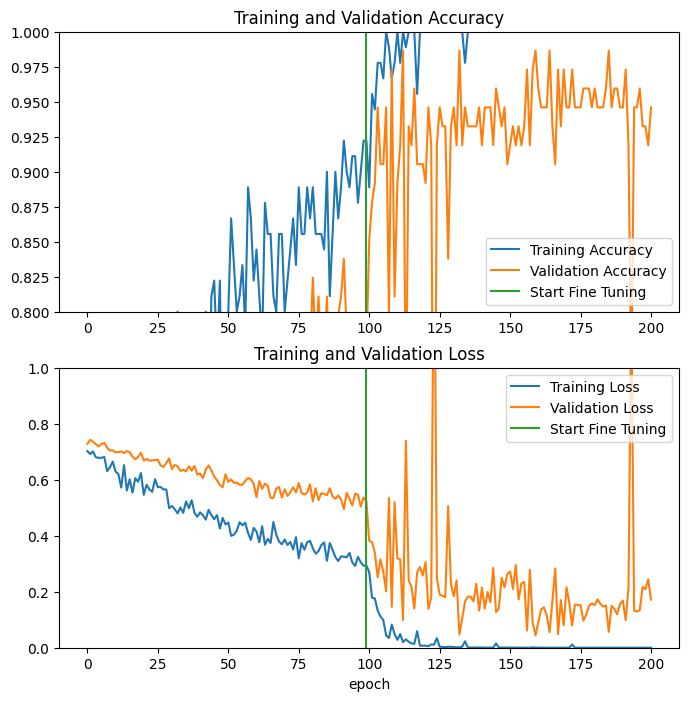

In [148]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

### 평가 및 예측

마지막으로 테스트 세트를 사용하여 새 데이터에 대한 모델의 성능을 확인할 수 있습니다.

In [149]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 0s 42ms/step - loss: 0.7878 - accuracy: 0.8125
Test accuracy : 0.8125


이제 이 모델을 사용하여 부품이 정상인지 불량인지 예측할 준비가 되었습니다.

Predictions:
 [1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0]
Labels:
 [1 1 1 0 1 1 0 0 1 1 1 0 1 0 1 0]


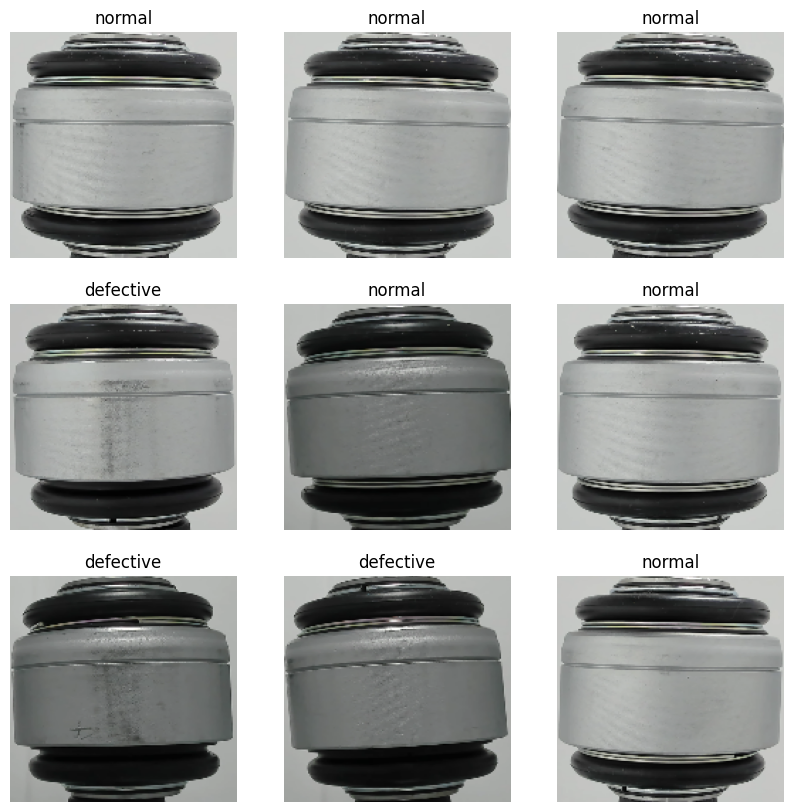

In [150]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")